Домашнее задание
Как узнать свою аудиторию? Построение различных вариантов кластеризаций и интерпретация результатов.

Цель:
На этот раз займемся классической задачкой - сегментация клиентов (в данном случае - банка). Крайне полезная операция, которая позволяет вам лучше познакомится со своей аудиторией, понять, на какие группы она делится и чем они характеризуются.


Описание/Пошаговая инструкция выполнения домашнего задания:

Часть 1. EDA и Preprocessing.
 - 1.Скачайте данные по клиентам немецкого банка: https://www.kaggle.com/uciml/german-credit;
 - 2.Проведите EDA, чтобы познакомиться с признаками;
 - 3.Преобразуйте все признаки в числовые подходящими методами;
 - 4.Приведите все данные к одному масштабу (а заодно поясните, почему это необходимая операция при кластеризации).

Часть 2. Моделирование.
 - 1.Постройте три варианта кластеризации: k-means, hierarhical и DBSCAN, подберите оптимальное количество кластеров для каждого метода при помощи Elbow method и Silhouette plot;
 - 2.Также воспользуйтесь различными вариантами сжатия признакового пространства (PCA, UMAP, tSNE) и визуализируйте результаты кластеризации на двумерной плоскости.

Часть 3. Интерпретация.
 - 1.Теперь ваша задача - попытаться проинтерпретировать получившиеся кластеры, начните с простого расчета средних значений признаков для каждого из кластеров, есть ли интересные закономерности?
 - 2.Теперь постройте boxplot-ы для каждого признака, сгруппировав значения по кластерам, по каким признакам заметно наибольшее отличие кластеров друг от друга? Можно ли их интерпретировать?

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Hierarhical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

#DBSCAN
from sklearn.cluster import DBSCAN

#визуализация (снижение размерности)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Часть 1. EDA и Preprocessing.

## 1.Скачайте данные по клиентам немецкого банка: https://www.kaggle.com/uciml/german-credit;

In [2]:
data = pd.read_csv('german_credit_data.csv')

In [3]:
df = data.copy() # копирую в переменную для работы
df.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [4]:
df.shape #кол-во столбцов, строк

(1000, 10)

In [5]:
df.info() #информация по столбцам: типы, non-null, кол-во

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [6]:
data.describe()  #базовые статистики датасета: средние, медиана, персентили

Unnamed: 0          Age          Job  Credit amount     Duration
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.000000
mean    499.500000    35.546000     1.904000    3271.258000    20.903000
std     288.819436    11.375469     0.653614    2822.736876    12.058814
min       0.000000    19.000000     0.000000     250.000000     4.000000
25%     249.750000    27.000000     2.000000    1365.500000    12.000000
50%     499.500000    33.000000     2.000000    2319.500000    18.000000
75%     749.250000    42.000000     2.000000    3972.250000    24.000000
max     999.000000    75.000000     3.000000   18424.000000    72.000000

### Вывод: скачал данные, посмотрел размеры, df.info(), data.describe().
 - есть пропуски
 - разные масштабы
 -  Unnamed: 0 - индекс

## 2.Проведите EDA, чтобы познакомиться с признаками;

In [7]:
# Unnamed: 0 - индекс -> удалить
df.drop(columns = 'Unnamed: 0', inplace = True)

In [8]:
df.shape # столбцов стало 9

(1000, 9)

### Пропуски

In [9]:
df.isnull().sum() # посмотреть наполняемость

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [10]:
df.isna().sum()/df.shape[0] # посмотреть % наполняемость

Age                 0.000
Sex                 0.000
Job                 0.000
Housing             0.000
Saving accounts     0.183
Checking account    0.394
Credit amount       0.000
Duration            0.000
Purpose             0.000
dtype: float64

In [11]:
# Saving accounts - сберегательный счет
# Checking account - текущий чековый счет

### Обработка колонок

In [12]:
# колонки по типам данных
df.dtypes.value_counts() # посмотреть колонки по типам данных

object    5
int64     4
dtype: int64

In [13]:
df.select_dtypes(['int64']).columns

Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')

In [14]:
df.select_dtypes(['object']).columns

Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], dtype='object')

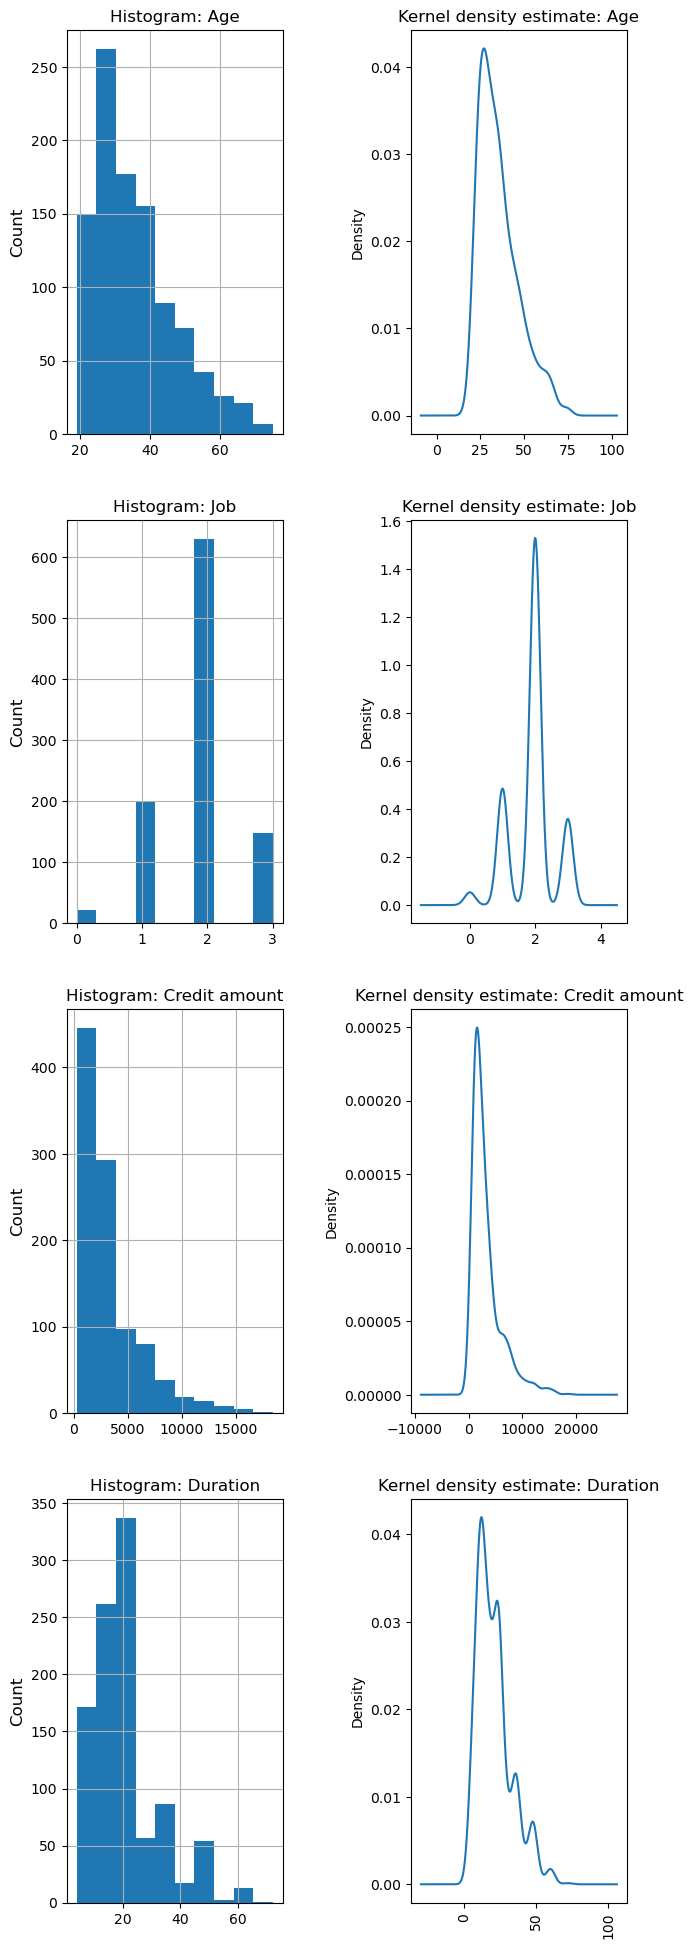

In [15]:
# выведу графики и сделаю выводы. Для ознакомления, может что-то будет подозрительное (спойлер - ничего!)
columns_temp = df.select_dtypes(['int64']).columns

fig, axs = plt.subplots(nrows=len(columns_temp), ncols=2, figsize=(7,20))

for index, column in enumerate(columns_temp):
    # В первом столбце гистограмма
    df[column].hist(ax=axs[index, 0])
    axs[index, 0].set_title(f'Histogram: {column}', fontsize=12)
    axs[index, 0].set_ylabel('Count', fontsize=12)
        
    # Во втором столбце график сглаженной плотности распределения на основе ядерной оценки
    df[column].plot(kind='kde', ax=axs[index, 1])
    axs[index, 1].set_title(f'Kernel density estimate: {column}', fontsize=12)

plt.tight_layout(pad=3.0)
plt.xticks(rotation='vertical')
plt.show()

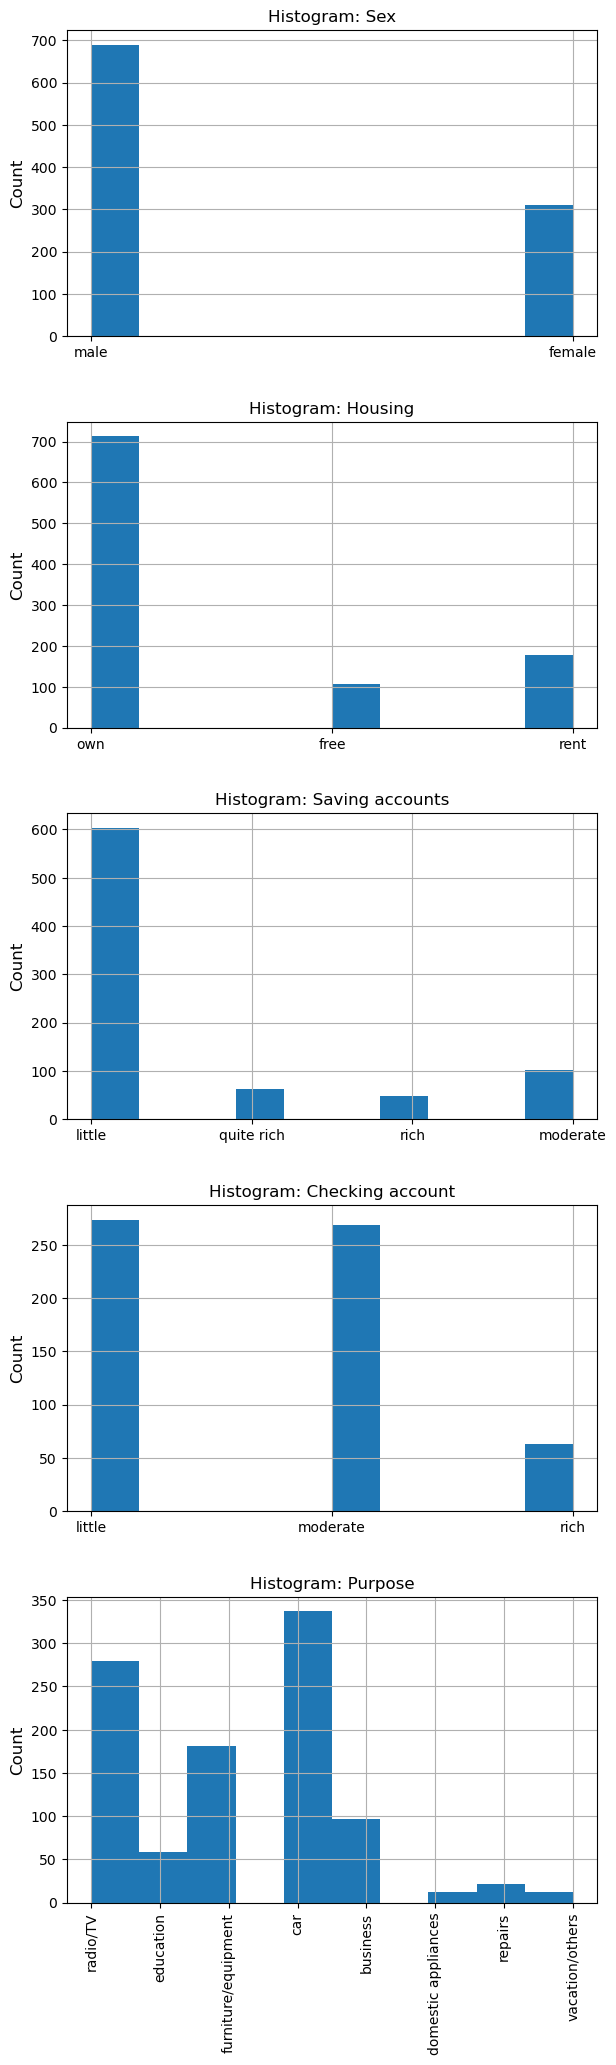

In [16]:
# выведу графики и сделаю выводы. Для ознакомления, может что-то будет подозрительное (спойлер - не забыть про NaN!)
# Saving accounts - сберегательный счет
# Checking account - текущий чековый счет
columns_temp = df.select_dtypes(['object']).columns

fig, axs = plt.subplots(nrows=len(columns_temp), ncols=1, figsize=(7,20))

for index, column in enumerate(columns_temp):
    # В первом столбце гистограмма
    df[column].hist(ax=axs[index])
    axs[index].set_title(f'Histogram: {column}', fontsize=12)
    axs[index].set_ylabel('Count', fontsize=12)
    
        
    # Во втором столбце график сглаженной плотности распределения на основе ядерной оценки
    #df[column].plot(kind='kde', ax=axs[index, 1])
    #axs[index, 1].set_title(f'Kernel density estimate: {column}', fontsize=12)

plt.tight_layout(pad=3.0)
plt.xticks(rotation='vertical')
plt.show()

## 3.Преобразуйте все признаки в числовые подходящими методами

#### Age - оставляю признак без измений

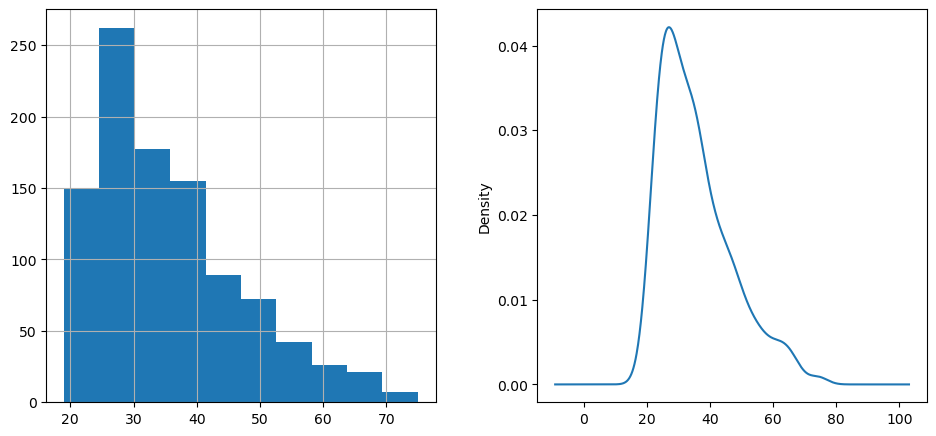

In [17]:
# ['Age', 'Job', 'Credit amount', 'Duration'] - возьму этот лист, чтобы не крутить ноутбук вверх-вниз
column = 'Age'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df[column].hist(ax=axs[0])
df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

#### Job - оставляю признак без измений

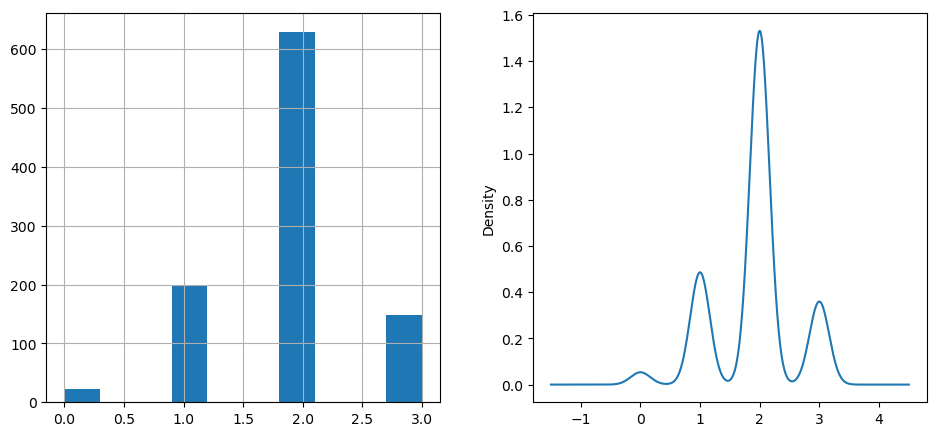

In [18]:
# ['Age', 'Job', 'Credit amount', 'Duration'] - возьму этот лист, чтобы не крутить ноутбук вверх-вниз
column = 'Job'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df[column].hist(ax=axs[0])
df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

In [19]:
df[column].value_counts(dropna=False)

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

#### Credit amount - оставляю признак без измений

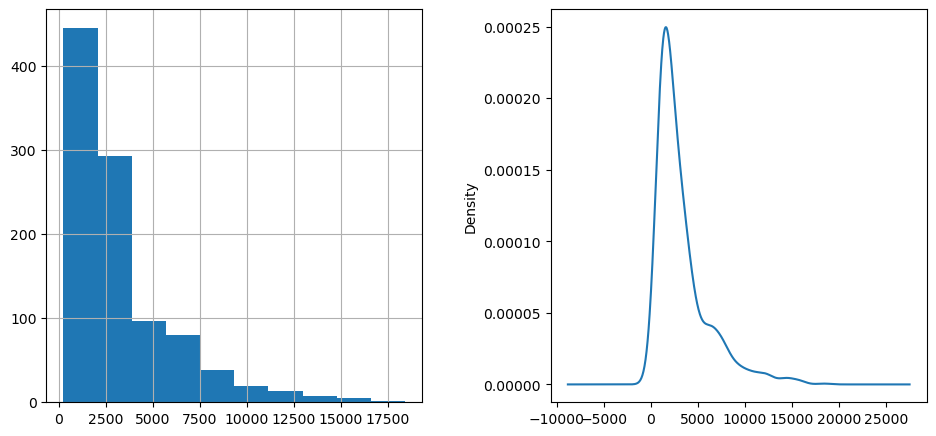

In [20]:
# ['Age', 'Job', 'Credit amount', 'Duration'] - возьму этот лист, чтобы не крутить ноутбук вверх-вниз
column = 'Credit amount'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df[column].hist(ax=axs[0])
df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

#### Duration - оставляю признак без измений

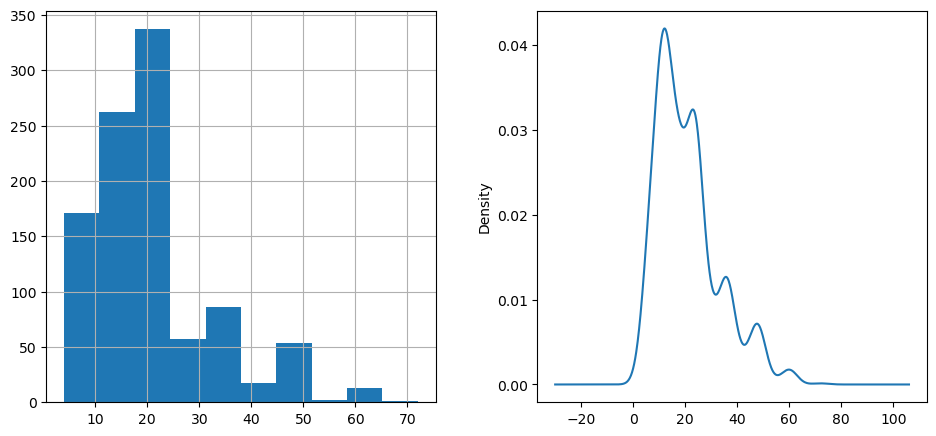

In [21]:
# ['Age', 'Job', 'Credit amount', 'Duration'] - возьму этот лист, чтобы не крутить ноутбук вверх-вниз
column = 'Duration'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df[column].hist(ax=axs[0])
df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

In [22]:
# для кодирования создам функцию 
def label_encoder(data_frame, column):
    column = column
    label_encoder = LabelEncoder() #создаю объект класса LabelEncoder
    column_code = column + '_code' #имя нового столбца
    data_frame[column_code] = label_encoder.fit_transform(data_frame[column]) #применяю fit_transform к label_encoder
    data_frame.drop(columns = [column], inplace = True) #удалю column из df
    return data_frame #возвращаю data-frame

#### Sex - преобразую в числовые данные с помощью LabelEncoder

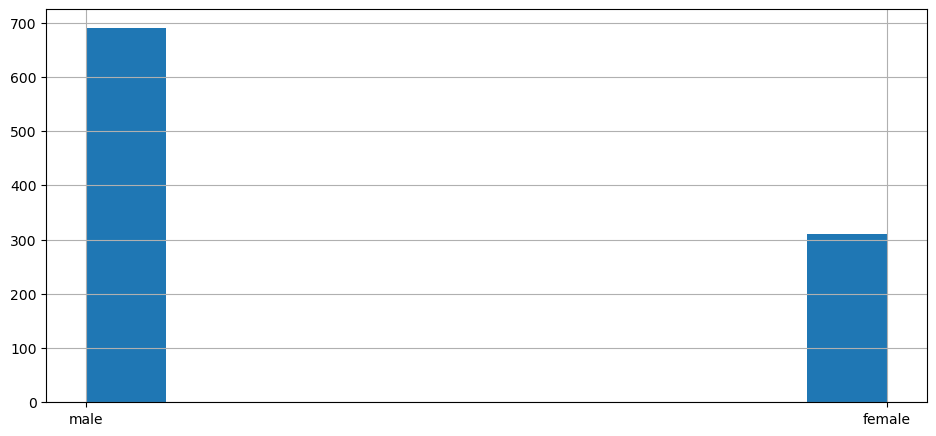

In [23]:
# ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'] - возьму этот лист, чтобы не крутить ноутбук вверх-вниз
column = 'Sex'
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
df[column].hist(ax=axs)
#df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

In [24]:
df[column].value_counts(dropna=False)

male      690
female    310
Name: Sex, dtype: int64

In [25]:
df = label_encoder(df, column)

#### Housing - преобразую в числовые данные с помощью LabelEncoder

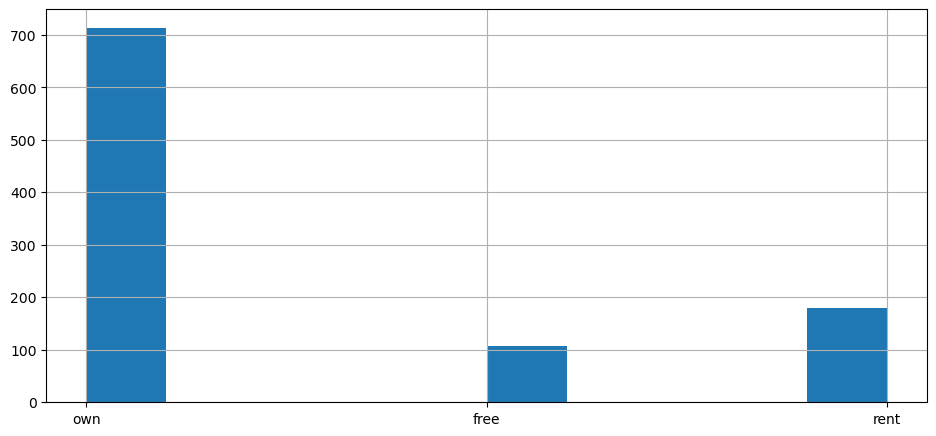

In [26]:
# ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'] - возьму этот лист, чтобы не крутить ноутбук вверх-вниз
column = 'Housing'
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
df[column].hist(ax=axs)
#df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

In [27]:
df[column].value_counts(dropna=False)

own     713
rent    179
free    108
Name: Housing, dtype: int64

In [28]:
df = label_encoder(df, column)

#### Saving accounts - преобразую в числовые данные с помощью LabelEncoder

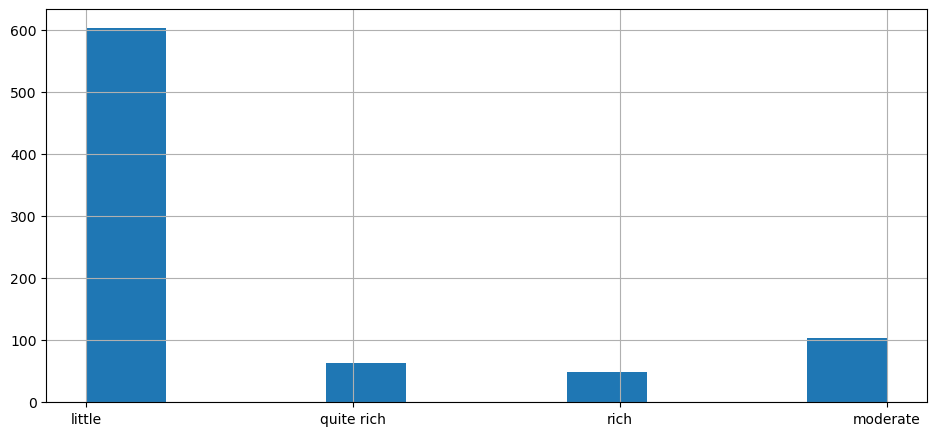

In [29]:
# ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'] - возьму этот лист, чтобы не крутить ноутбук вверх-вниз
column = 'Saving accounts'
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
df[column].hist(ax=axs)
#df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

In [30]:
df[column].value_counts(dropna=False) #тут NaN = сберегательный счет отсутствует (заменю на none)

little        603
NaN           183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [31]:
df[column].fillna('none', inplace=True)

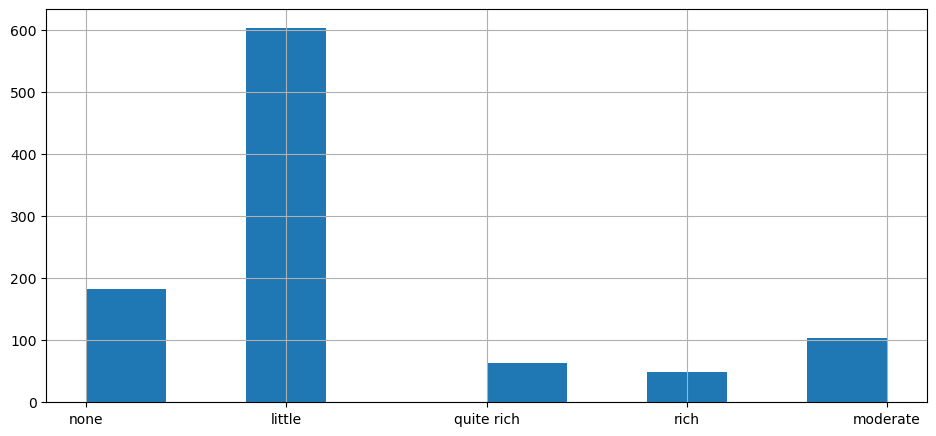

In [32]:
#после замены
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
df[column].hist(ax=axs)
#df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

In [33]:
df[column].value_counts(dropna=False) #после замены

little        603
none          183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [34]:
df = label_encoder(df, column)

#### Checking account - преобразую в числовые данные с помощью LabelEncoder

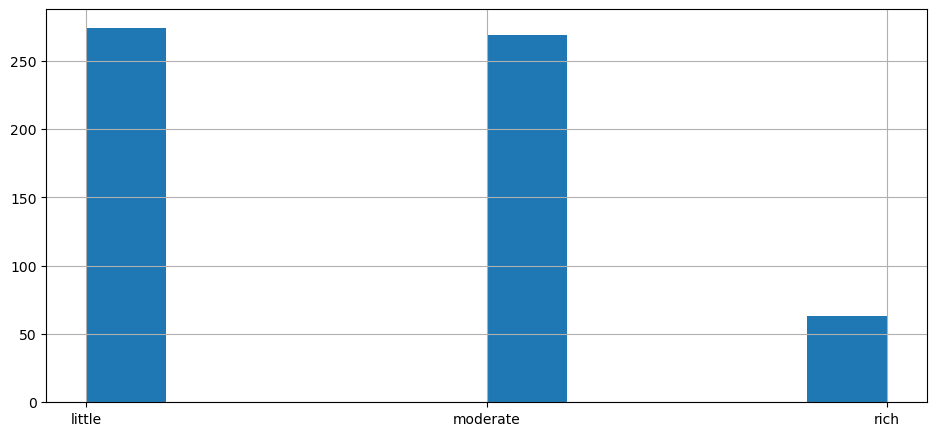

In [35]:
# ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'] - возьму этот лист, чтобы не крутить ноутбук вверх-вниз
column = 'Checking account'
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
df[column].hist(ax=axs)
#df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

In [36]:
df[column].value_counts(dropna=False) #тут NaN = текущий счет отсутствует (заменю на none)

NaN         394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [37]:
df[column].fillna('none', inplace=True)

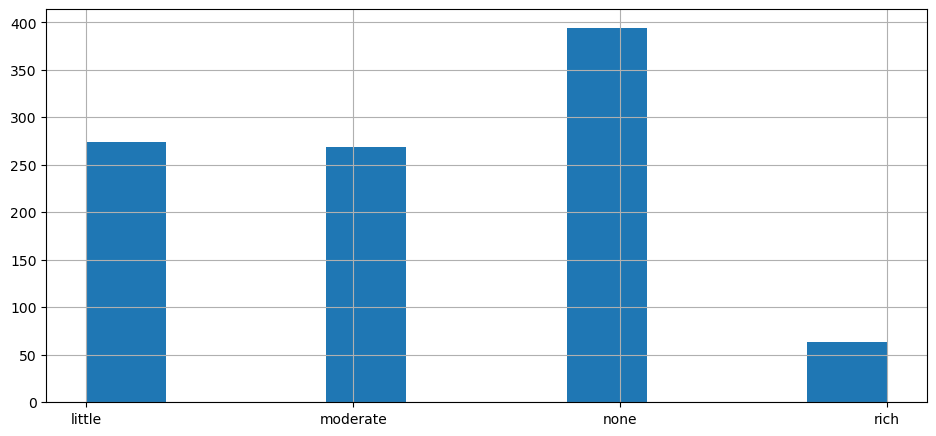

In [38]:
#после замены
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
df[column].hist(ax=axs)
#df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

In [39]:
df[column].value_counts(dropna=False) #после замены

none        394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [40]:
df = label_encoder(df, column)

#### Purpose - преобразую в числовые данные с помощью LabelEncoder

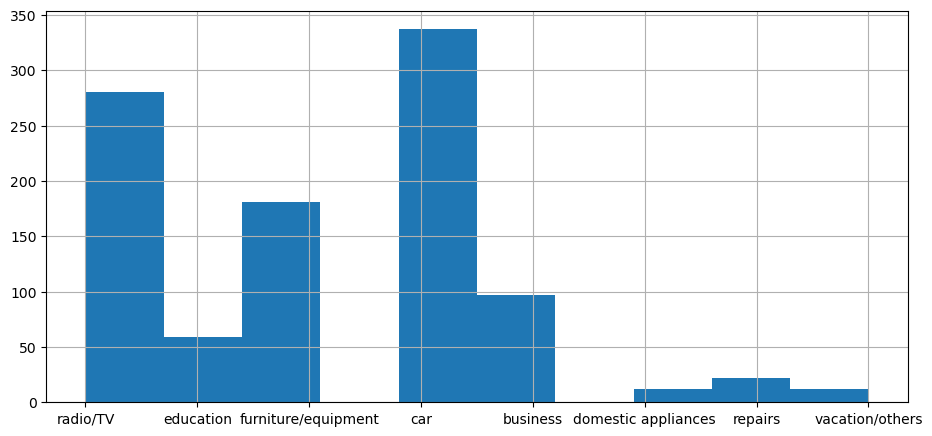

In [41]:
# ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'] - возьму этот лист, чтобы не крутить ноутбук вверх-вниз
column = 'Purpose'
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
df[column].hist(ax=axs)
#df[column].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

In [42]:
df[column].value_counts(dropna=False)

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64

In [43]:
df = label_encoder(df, column)

In [44]:
df.head(3)

Age  Job  Credit amount  Duration  Sex_code  Housing_code  \
0   67    2           1169         6         1             1   
1   22    2           5951        48         0             1   
2   49    1           2096        12         1             1   

   Saving accounts_code  Checking account_code  Purpose_code  
0                     2                      0             5  
1                     0                      1             5  
2                     0                      2             3

### Ознакомился с данными и закодировал

## 4.Приведите все данные к одному масштабу (а заодно поясните, почему это необходимая операция при кластеризации).

In [45]:
df.describe().loc[['mean', '50%', 'std']] #посмотрел основные метрики масштабов

Age       Job  Credit amount   Duration  Sex_code  Housing_code  \
mean  35.546000  1.904000    3271.258000  20.903000  0.690000      1.071000   
50%   33.000000  2.000000    2319.500000  18.000000  1.000000      1.000000   
std   11.375469  0.653614    2822.736876  12.058814  0.462725      0.531264   

      Saving accounts_code  Checking account_code  Purpose_code  
mean              0.850000               1.246000      2.878000  
50%               0.000000               1.000000      3.000000  
std               1.203723               0.927547      1.978138

In [46]:
scaler = StandardScaler() # создаю объект StandardScaler

In [47]:
# создаю скалированый дата-фрейм
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
df_scaled.head()

Age       Job  Credit amount  Duration  Sex_code  Housing_code  \
0  2.766456  0.146949      -0.745131 -1.236478  0.670280     -0.133710   
1 -1.191404  0.146949       0.949817  2.248194 -1.491914     -0.133710   
2  1.183312 -1.383771      -0.416562 -0.738668  0.670280     -0.133710   
3  0.831502  0.146949       1.634247  1.750384  0.670280     -2.016956   
4  1.535122  0.146949       0.566664  0.256953  0.670280     -2.016956   

   Saving accounts_code  Checking account_code  Purpose_code  
0              0.955847              -1.344000      1.073263  
1             -0.706496              -0.265348      1.073263  
2             -0.706496               0.813303      0.061705  
3             -0.706496              -1.344000      0.567484  
4             -0.706496              -1.344000     -0.949853

In [48]:
df_scaled.describe().loc[['mean', '50%', 'std']] #посмотрел основные метрики масштабов -> готово

Age           Job  Credit amount      Duration      Sex_code  \
mean  3.597123e-17  1.167400e-16   7.771561e-17  1.332268e-16 -4.418688e-17   
50%  -2.239269e-01  1.469492e-01  -3.373443e-01 -2.408572e-01  6.702801e-01   
std   1.000500e+00  1.000500e+00   1.000500e+00  1.000500e+00  1.000500e+00   

      Housing_code  Saving accounts_code  Checking account_code  Purpose_code  
mean -2.598477e-16          4.839185e-17          -5.628831e-17 -2.797762e-16  
50%  -1.337105e-01         -7.064959e-01          -2.653482e-01  6.170503e-02  
std   1.000500e+00          1.000500e+00           1.000500e+00  1.000500e+00

#### разные масштабы - нужно масштабирование

# Часть 2. Моделирование.

## 1.Постройте три варианта кластеризации: k-means, hierarhical и DBSCAN, подберите оптимальное количество кластеров для каждого метода при помощи Elbow method и Silhouette plot;

In [49]:
X = df_scaled #матрица признаков

### k-means

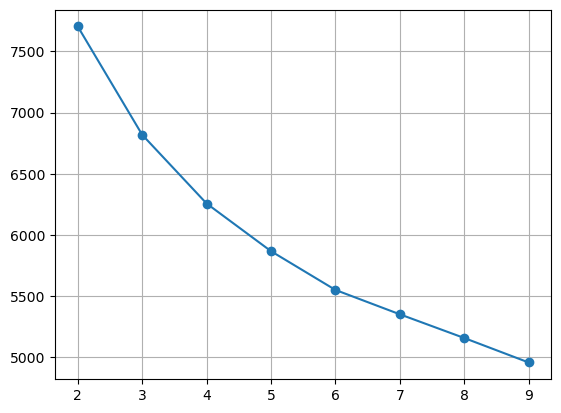

In [50]:
#Подбераю оптимальное количество кластеров с помощью метода локтя и силуэта графика
inertia = []
silhouette_scores = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
plt.grid()
plt.plot(range(2,10), inertia, marker='o')

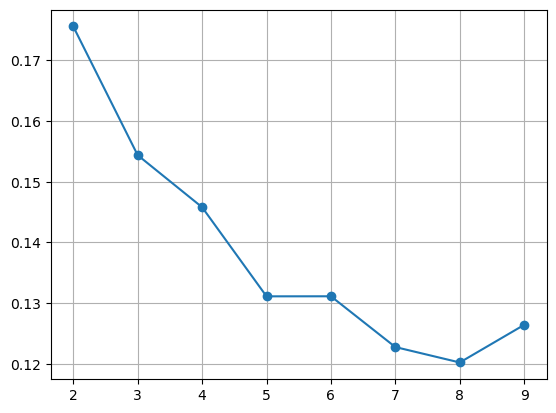

In [51]:
#Метод силуэта

plt.grid()
plt.plot(range(2,10), silhouette_scores, marker='o');

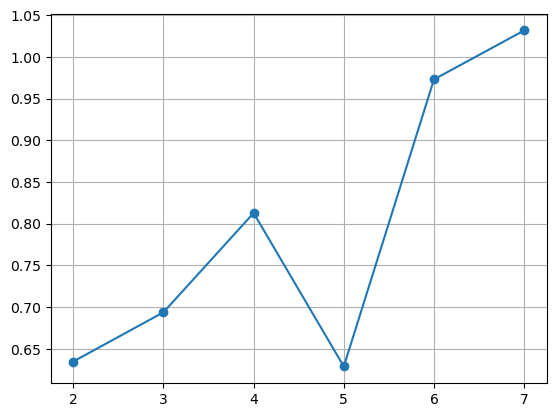

In [52]:
# инерция

D = []
for i in range(1,7):
    D.append((inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i]))
    
plt.grid()
plt.plot(range(2,8), D, marker='o')    

#### Вывод: оптимальным количеством кластеров будет 3 или 5

In [53]:
# функция для визуализации
def visualization_by_methon(X, clusters, reducer, name):    
    X_reduced = reducer.fit_transform(X)

    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        x=X_reduced[:, 0], 
        y=X_reduced[:, 1], 
        hue=clusters, 
        palette="bright",
        legend='full'
    )    
    plt.title(f'снижение размероности методом {name}' , fontsize=18)
    plt.grid()
    plt.show()
    
def visualization(X, clusters):
    visualization_by_methon(X, clusters, PCA(n_components=2), 'PCA')
    visualization_by_methon(X, clusters, umap.UMAP(n_components=2), 'UMAP')
    visualization_by_methon(X, clusters, TSNE(n_components=2), 'TSNE')

In [54]:
# количество кластеров будет 3 
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=7)
kmeans.fit(X)

df_clustered_kmeans = df.copy()
df_clustered_kmeans['Cluster'] = kmeans.labels_

df_clustered_kmeans.head()

Age  Job  Credit amount  Duration  Sex_code  Housing_code  \
0   67    2           1169         6         1             1   
1   22    2           5951        48         0             1   
2   49    1           2096        12         1             1   
3   45    2           7882        42         1             0   
4   53    2           4870        24         1             0   

   Saving accounts_code  Checking account_code  Purpose_code  Cluster  
0                     2                      0             5        1  
1                     0                      1             5        0  
2                     0                      2             3        1  
3                     0                      0             4        0  
4                     0                      0             1        0

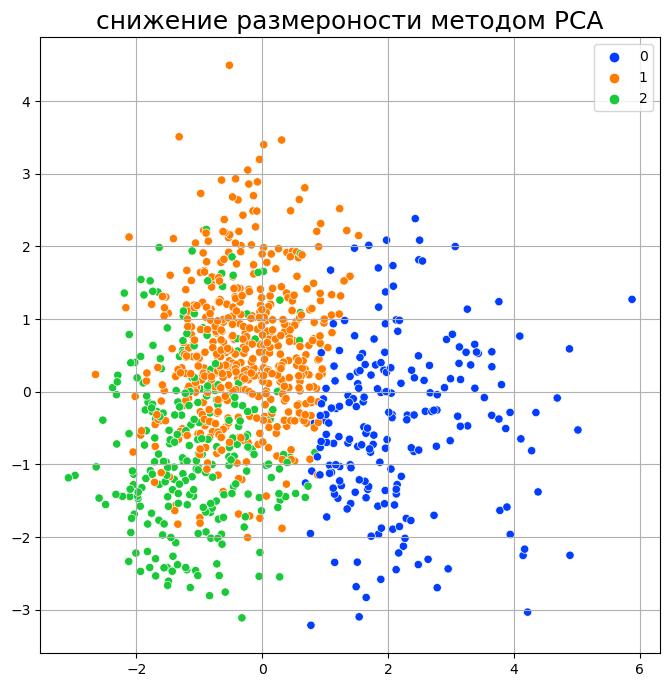

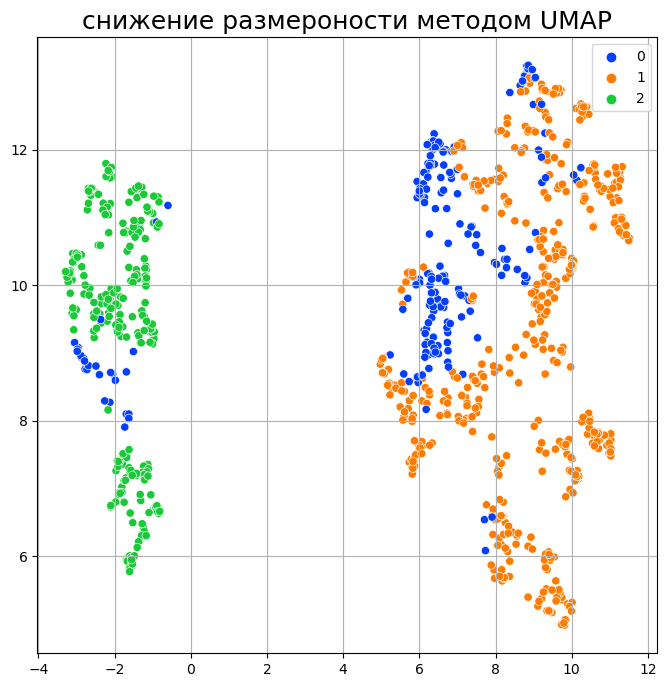

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


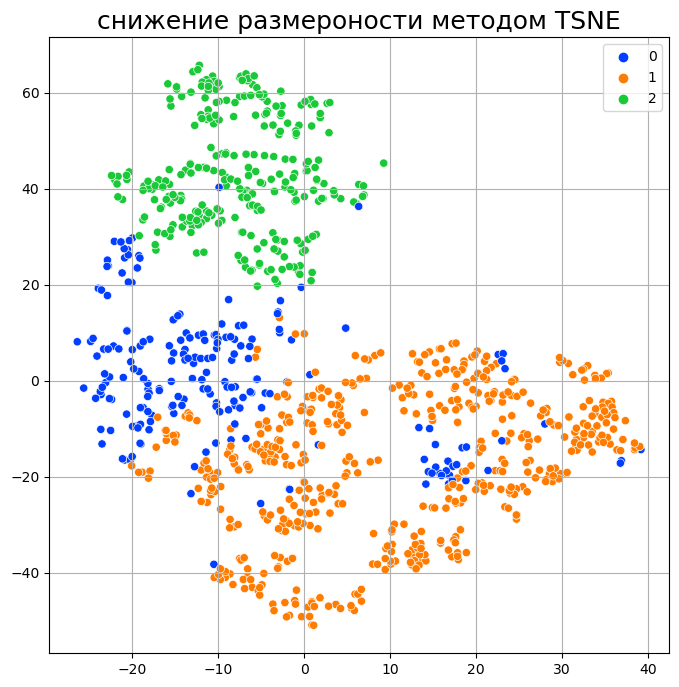

In [55]:
visualization(X, kmeans.labels_)

In [56]:
# количество кластеров будет 4 
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=7)
kmeans.fit(X)

df_clustered_kmeans = df.copy()
df_clustered_kmeans['Cluster'] = kmeans.labels_

df_clustered_kmeans.head()

Age  Job  Credit amount  Duration  Sex_code  Housing_code  \
0   67    2           1169         6         1             1   
1   22    2           5951        48         0             1   
2   49    1           2096        12         1             1   
3   45    2           7882        42         1             0   
4   53    2           4870        24         1             0   

   Saving accounts_code  Checking account_code  Purpose_code  Cluster  
0                     2                      0             5        2  
1                     0                      1             5        0  
2                     0                      2             3        3  
3                     0                      0             4        0  
4                     0                      0             1        0

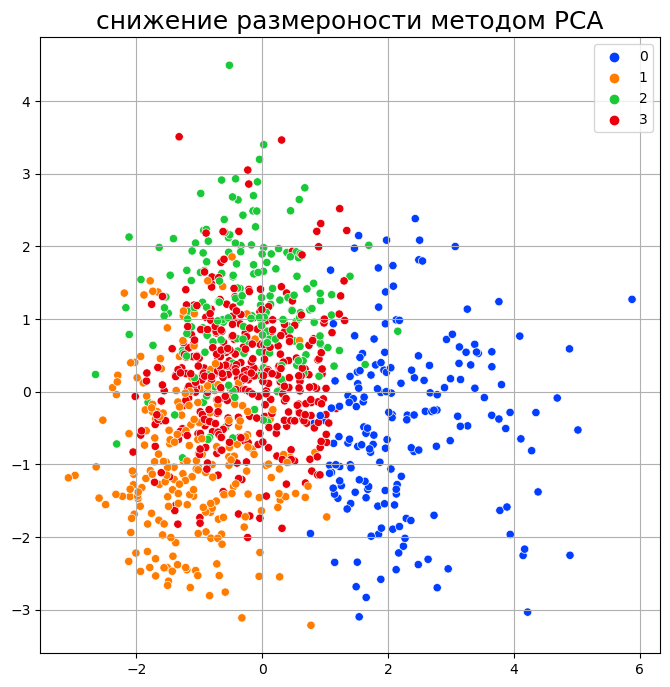

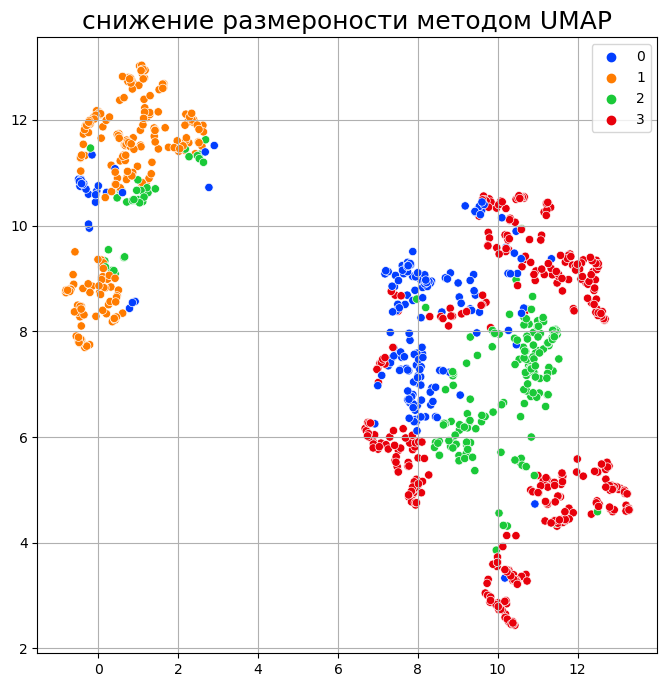

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


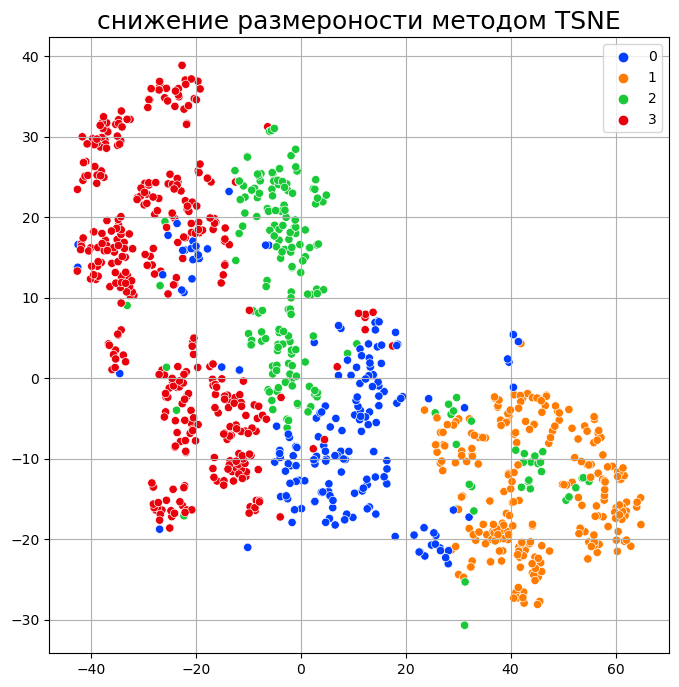

In [57]:
visualization(X, kmeans.labels_)

In [58]:
# количество кластеров будет 5
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=7)
kmeans.fit(X)

df_clustered_kmeans = df.copy()
df_clustered_kmeans['Cluster'] = kmeans.labels_

df_clustered_kmeans.head()

Age  Job  Credit amount  Duration  Sex_code  Housing_code  \
0   67    2           1169         6         1             1   
1   22    2           5951        48         0             1   
2   49    1           2096        12         1             1   
3   45    2           7882        42         1             0   
4   53    2           4870        24         1             0   

   Saving accounts_code  Checking account_code  Purpose_code  Cluster  
0                     2                      0             5        0  
1                     0                      1             5        1  
2                     0                      2             3        2  
3                     0                      0             4        1  
4                     0                      0             1        2

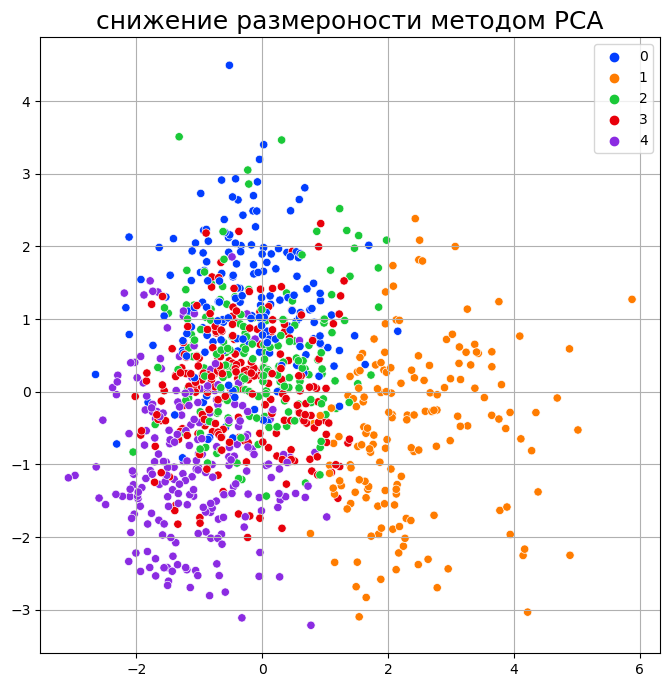

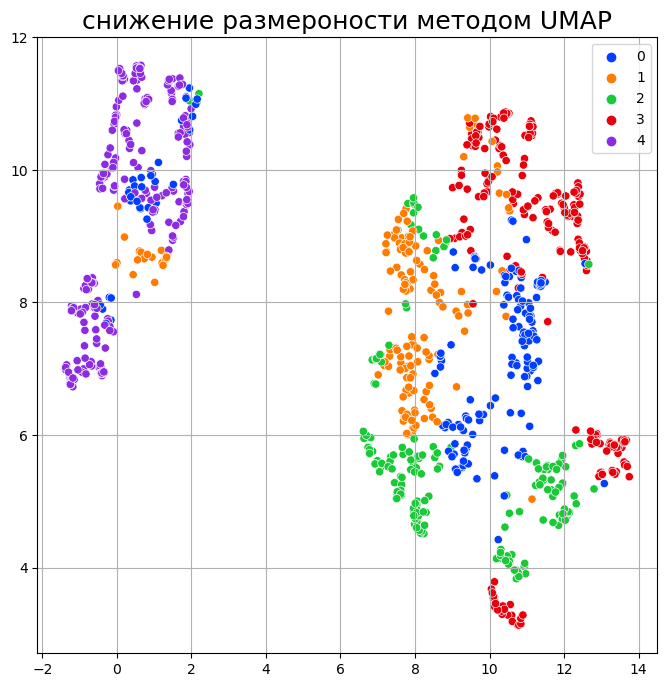

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


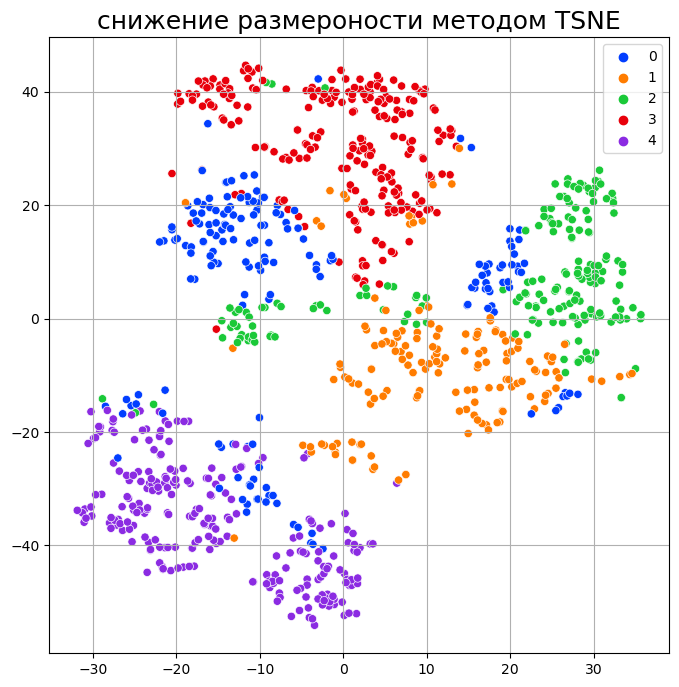

In [59]:
visualization(X, kmeans.labels_)

#### Вывод: можно выделить 5 кластеров!

### 2 Hierarhical clustering

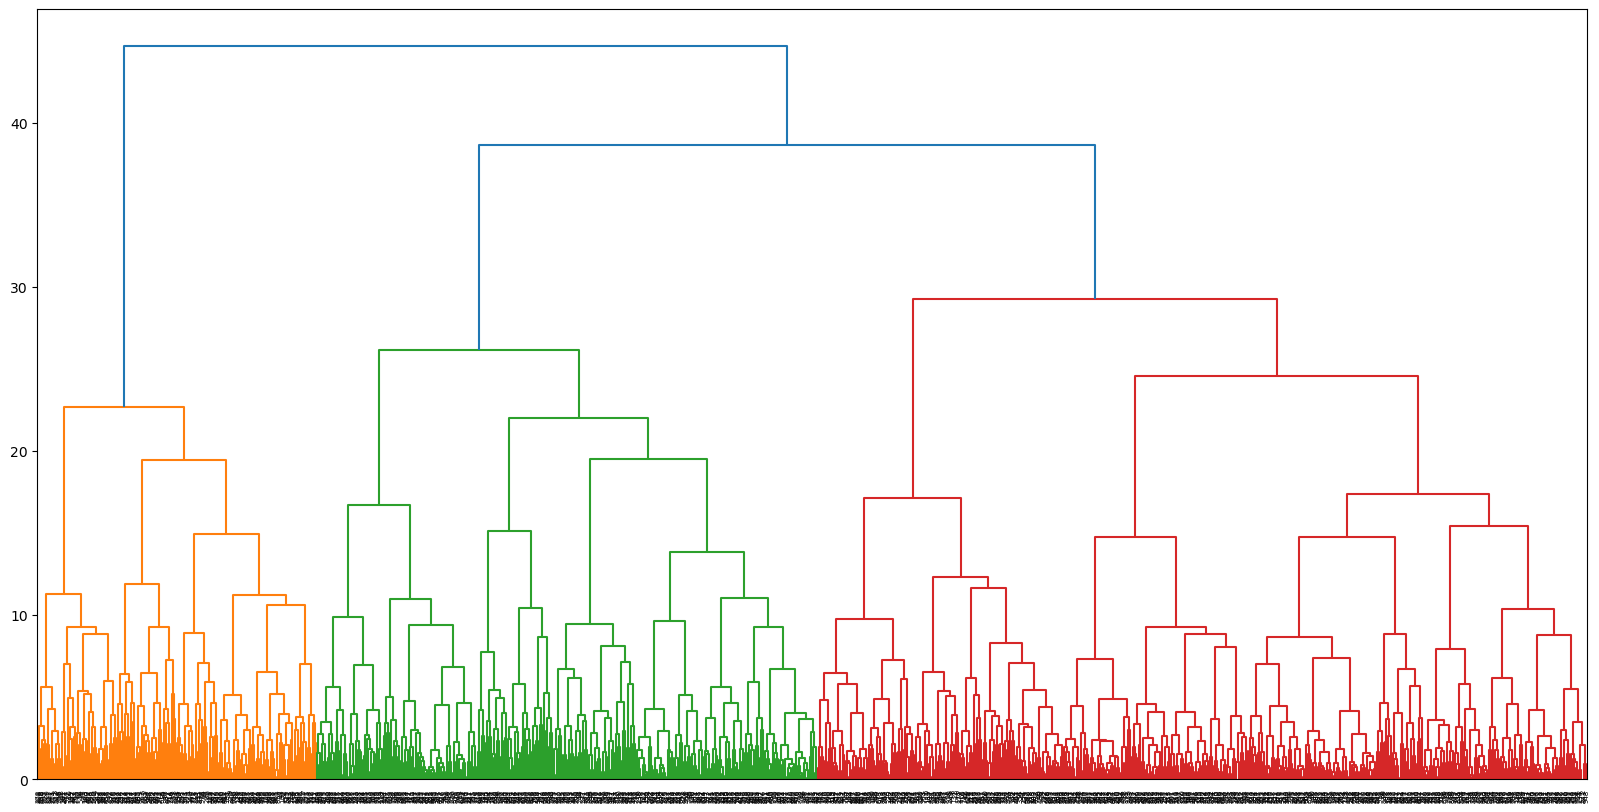

In [60]:
# построю дендограмму
plt.figure(figsize=(20,10))
linkage_ = linkage(X, method='ward')
dendrogram_ = dendrogram(linkage_)

#### Из дендограммы видно, что оптимальным количеством кластеров будет 3 - 5

In [62]:
n_clusters = 3
agglom_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agglom_clustering.fit(X)

df_clustered_agglom = df.copy()
df_clustered_agglom['Cluster'] = agglom_clustering.labels_

df_clustered_agglom.head()

Age  Job  Credit amount  Duration  Sex_code  Housing_code  \
0   67    2           1169         6         1             1   
1   22    2           5951        48         0             1   
2   49    1           2096        12         1             1   
3   45    2           7882        42         1             0   
4   53    2           4870        24         1             0   

   Saving accounts_code  Checking account_code  Purpose_code  Cluster  
0                     2                      0             5        0  
1                     0                      1             5        1  
2                     0                      2             3        0  
3                     0                      0             4        1  
4                     0                      0             1        1

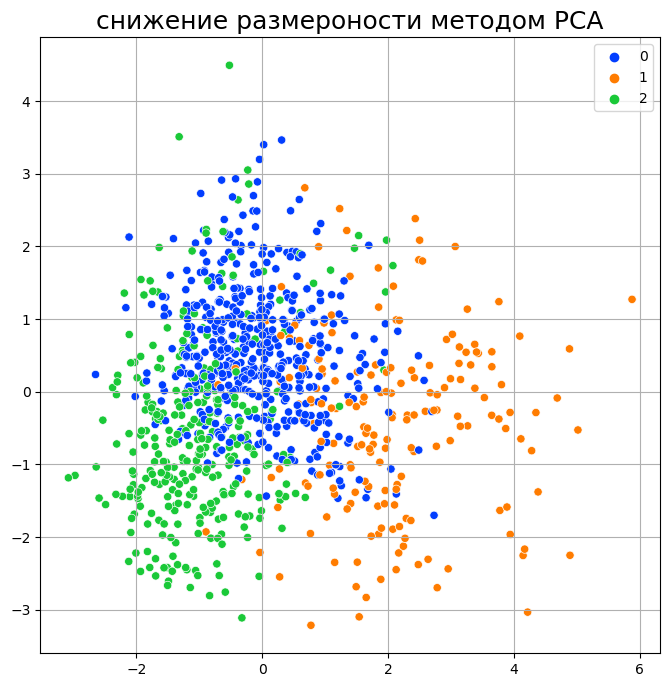

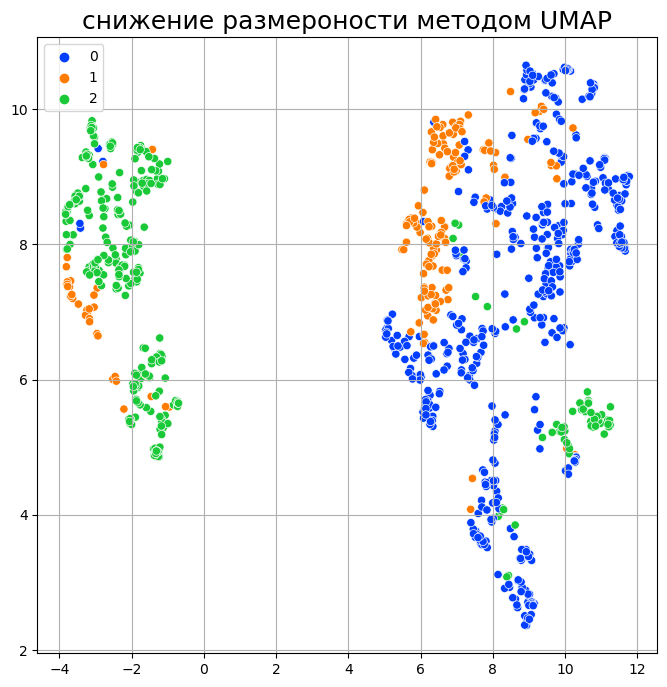

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


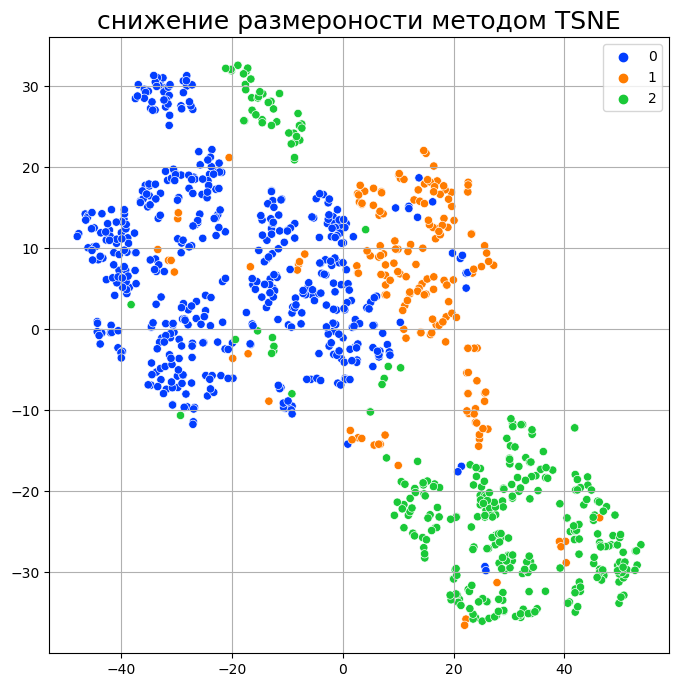

In [63]:
visualization(X, agglom_clustering.labels_)

In [65]:
n_clusters = 4
agglom_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agglom_clustering.fit(X)

df_clustered_agglom = df.copy()
df_clustered_agglom['Cluster'] = agglom_clustering.labels_

df_clustered_agglom.head()

Age  Job  Credit amount  Duration  Sex_code  Housing_code  \
0   67    2           1169         6         1             1   
1   22    2           5951        48         0             1   
2   49    1           2096        12         1             1   
3   45    2           7882        42         1             0   
4   53    2           4870        24         1             0   

   Saving accounts_code  Checking account_code  Purpose_code  Cluster  
0                     2                      0             5        3  
1                     0                      1             5        1  
2                     0                      2             3        2  
3                     0                      0             4        1  
4                     0                      0             1        1

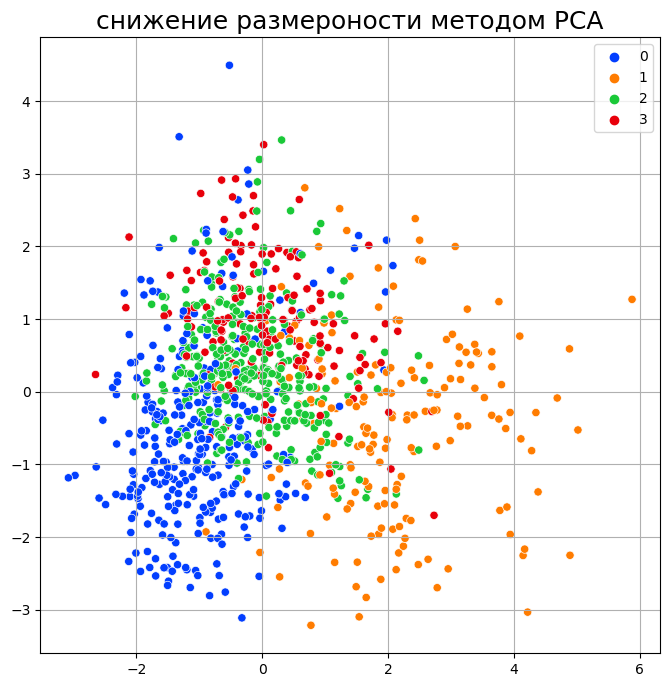

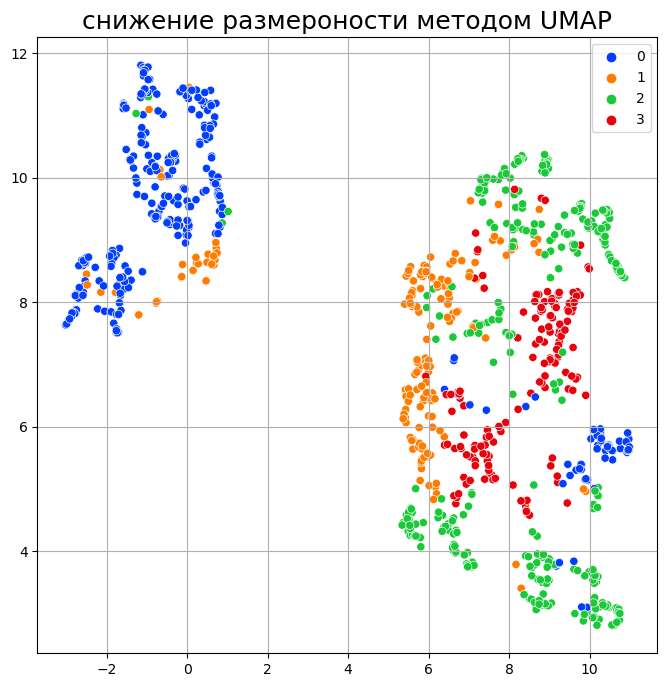

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


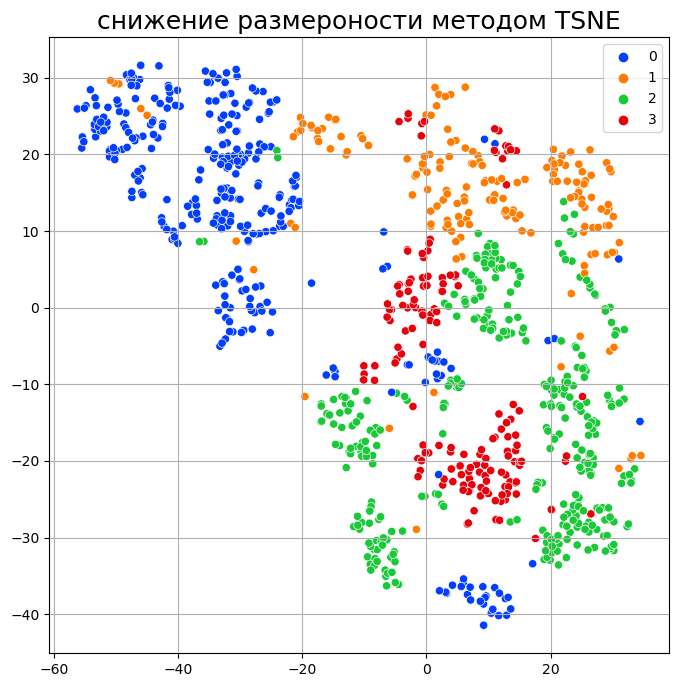

In [66]:
visualization(X, agglom_clustering.labels_)

In [68]:
n_clusters = 5
agglom_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agglom_clustering.fit(X)

df_clustered_agglom = df.copy()
df_clustered_agglom['Cluster'] = agglom_clustering.labels_

df_clustered_agglom.head()

Age  Job  Credit amount  Duration  Sex_code  Housing_code  \
0   67    2           1169         6         1             1   
1   22    2           5951        48         0             1   
2   49    1           2096        12         1             1   
3   45    2           7882        42         1             0   
4   53    2           4870        24         1             0   

   Saving accounts_code  Checking account_code  Purpose_code  Cluster  
0                     2                      0             5        3  
1                     0                      1             5        1  
2                     0                      2             3        0  
3                     0                      0             4        1  
4                     0                      0             1        1

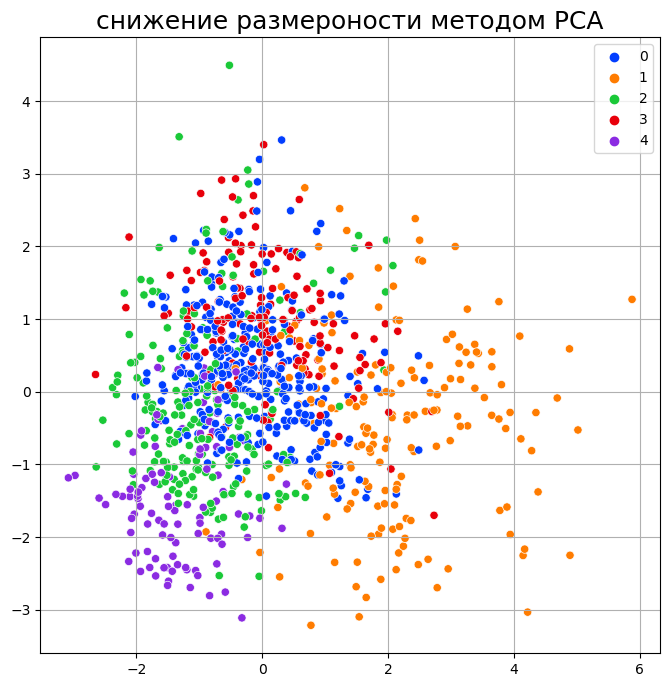

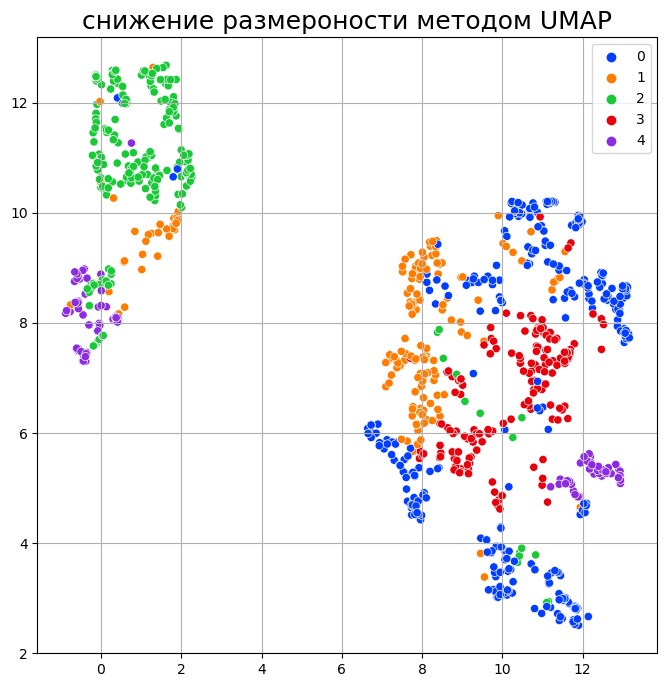

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


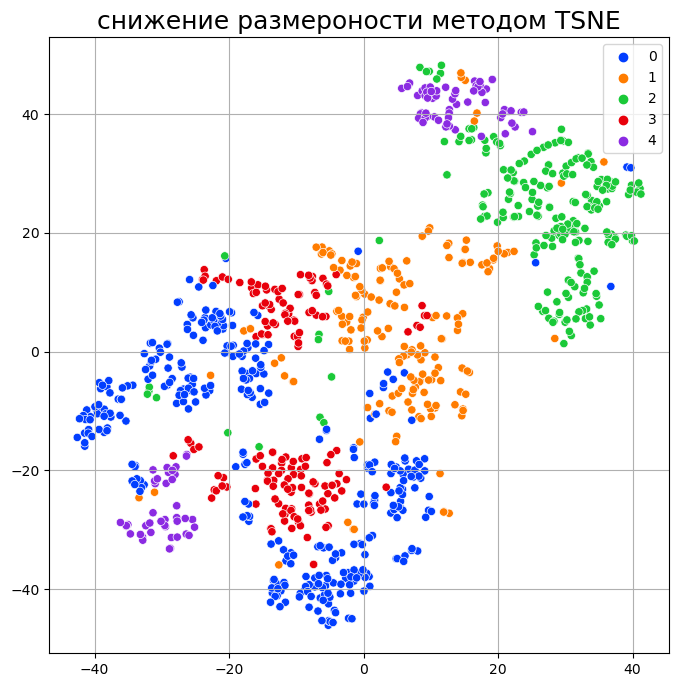

In [69]:
visualization(X, agglom_clustering.labels_)

#### Вывод: можно выделить 5 кластеров!

### 3 DBScan

In [70]:
dbscan = DBSCAN()
dbscan.fit(X)

df_clustered_dbscan = df.copy()
df_clustered_dbscan['Cluster'] = dbscan.labels_

df_clustered_dbscan.head()

Age  Job  Credit amount  Duration  Sex_code  Housing_code  \
0   67    2           1169         6         1             1   
1   22    2           5951        48         0             1   
2   49    1           2096        12         1             1   
3   45    2           7882        42         1             0   
4   53    2           4870        24         1             0   

   Saving accounts_code  Checking account_code  Purpose_code  Cluster  
0                     2                      0             5       -1  
1                     0                      1             5       -1  
2                     0                      2             3       -1  
3                     0                      0             4       -1  
4                     0                      0             1       -1

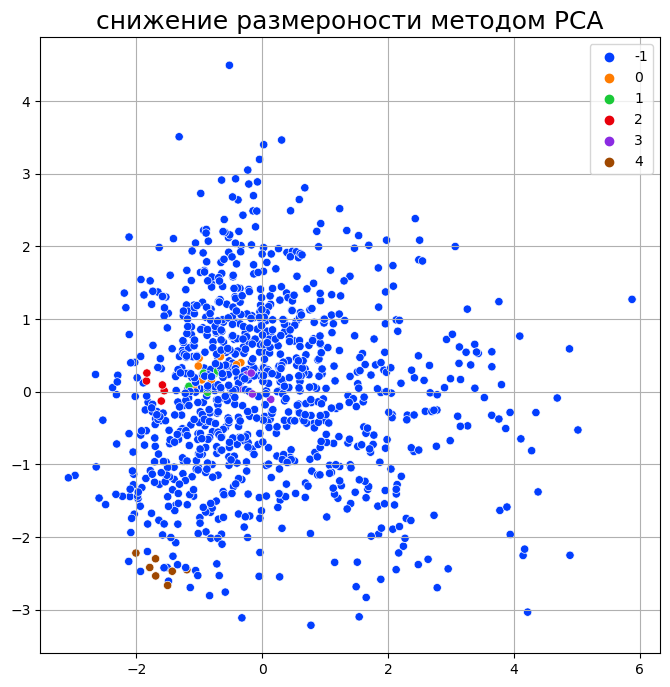

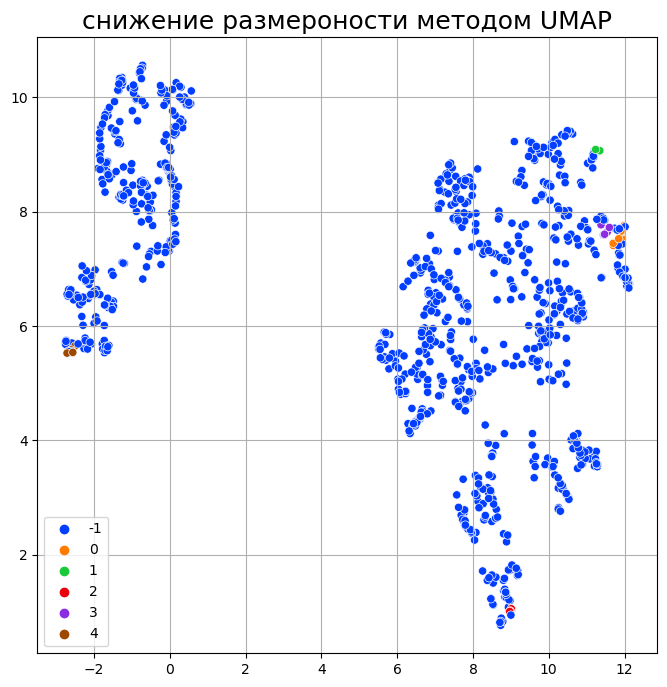

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


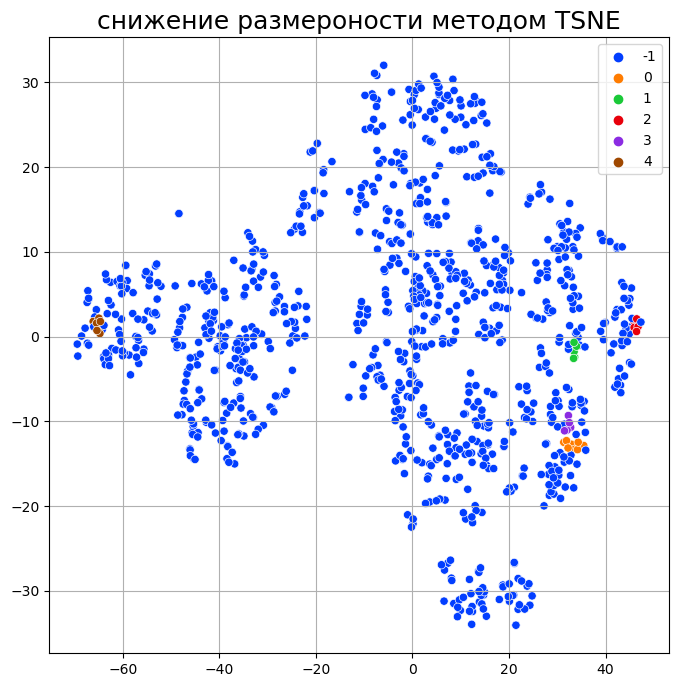

In [71]:
visualization(X, dbscan.labels_)

#### DBSCAN из коробки не очень хорошо справляется с текущей задачей: практически вся выборка попала в аномалии. Попробую подобрать параметр epsilon.

In [72]:
threshold = 0.05 #условие для выхода из цикла. когда счетчик outlier будет меньше и равен threshold - выйти из цикла
epsilon = 0.05 #начальное epsilon
outlier_percentage = 1. #счетчик outlier

epsilons_history = []
clusters_history = []
outliers_history = []

while outlier_percentage > threshold:        
    dbscan = DBSCAN(eps=epsilon)
    dbscan.fit(X)
    clusters = dbscan.labels_
    
    epsilons_history.append(epsilon)
    clusters_history.append(len(np.unique(clusters)) - 1)    
    
    outlier_percentage = sum(clusters == -1) / len(clusters)
    outliers_history.append(outlier_percentage)
    
    epsilon += 0.05 #добавтить шаг

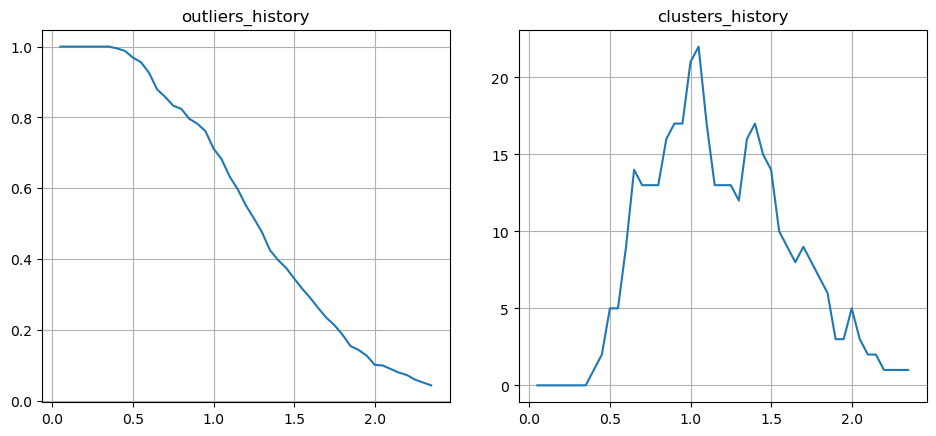

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].plot(epsilons_history, outliers_history)
axs[1].plot(epsilons_history, clusters_history)

axs[0].grid()
axs[0].set_title('outliers_history')
axs[1].grid()
axs[1].set_title('clusters_history')
plt.tight_layout(pad=3.0)
plt.show()

In [74]:
#выведу в принт -> число кластеров 3 - 5, epsilons = 2 - 2.05
print(clusters_history[-8:-6]) 
print(np.array(epsilons_history[-8:-6]))

[5, 3]
[2.   2.05]


2.0


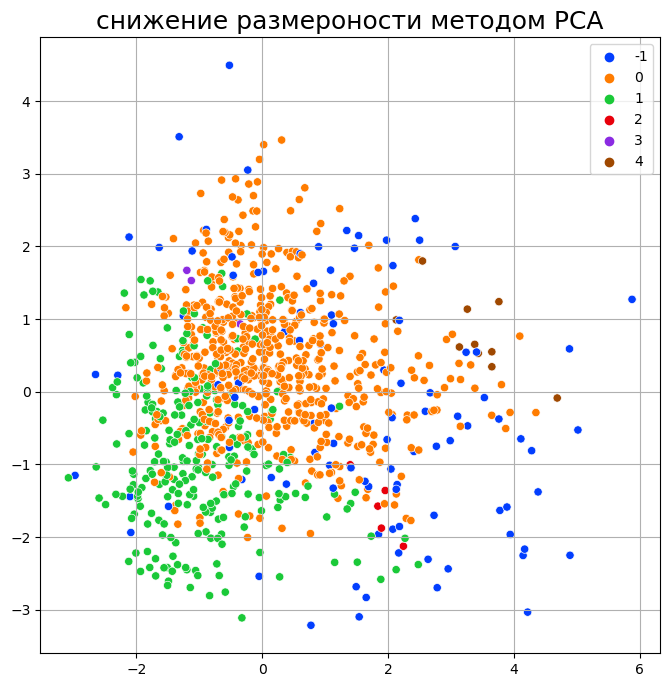

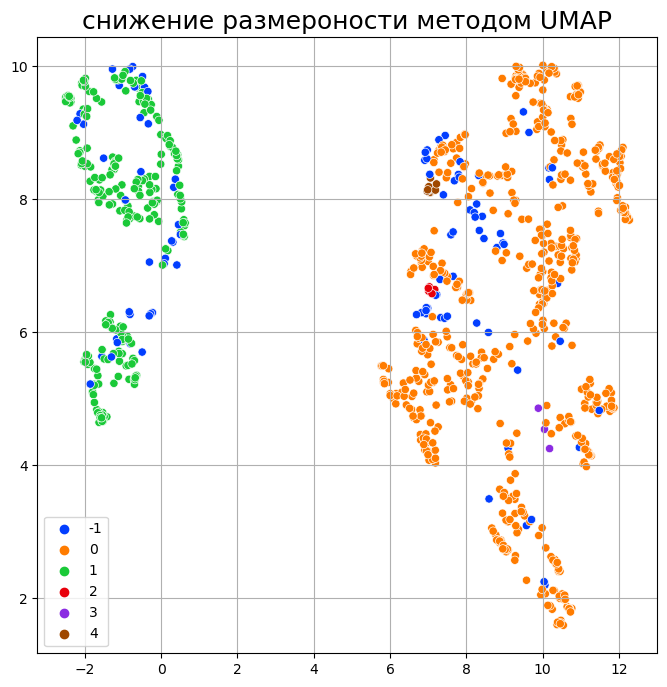

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


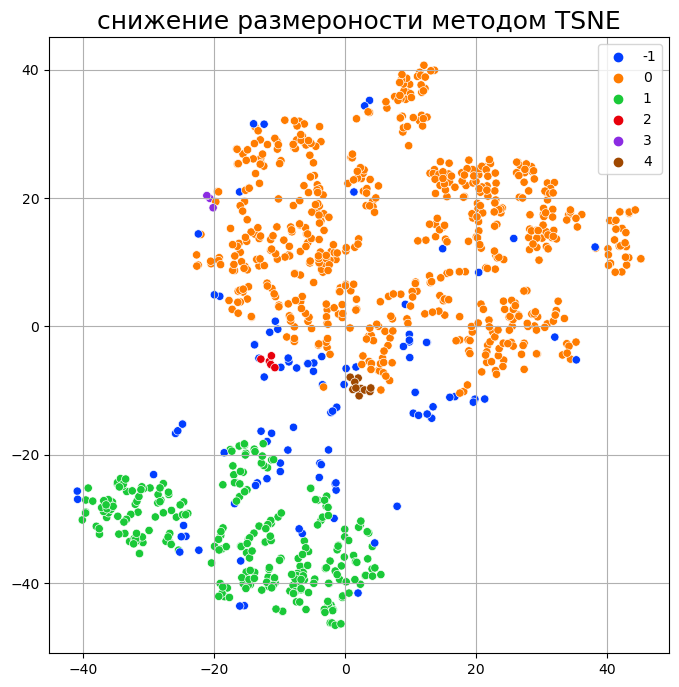

2.01


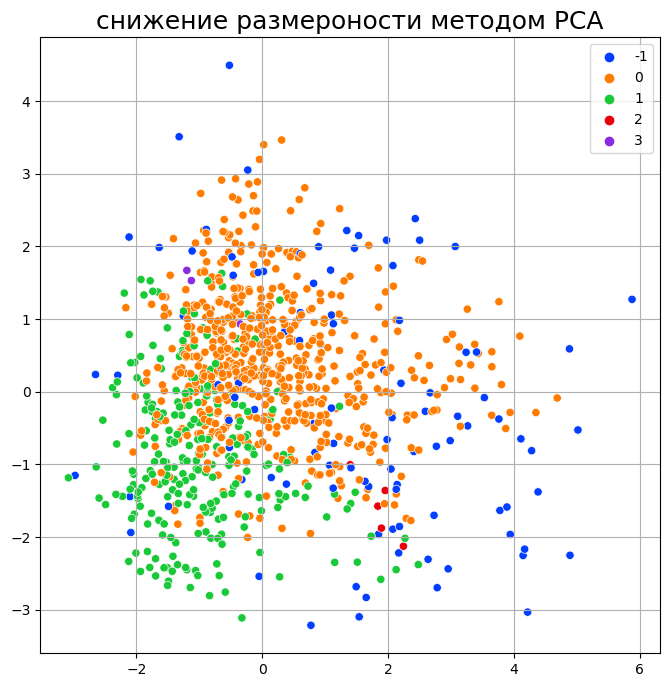

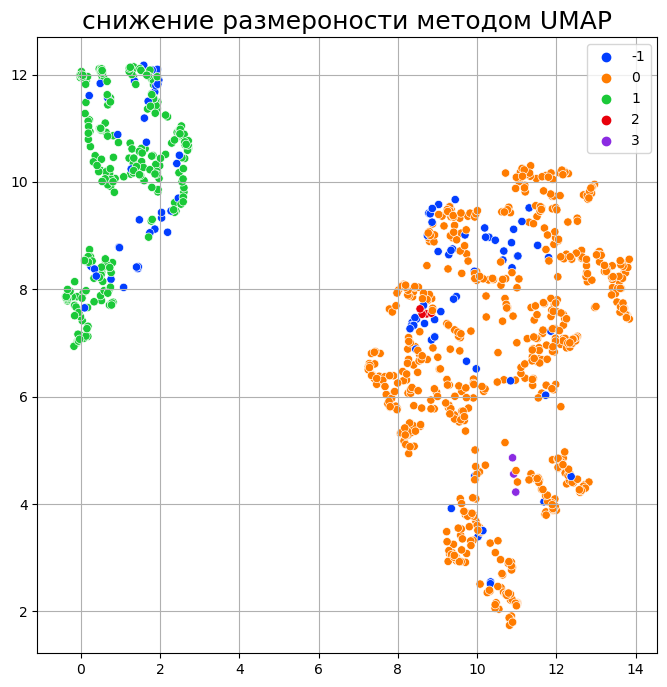

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


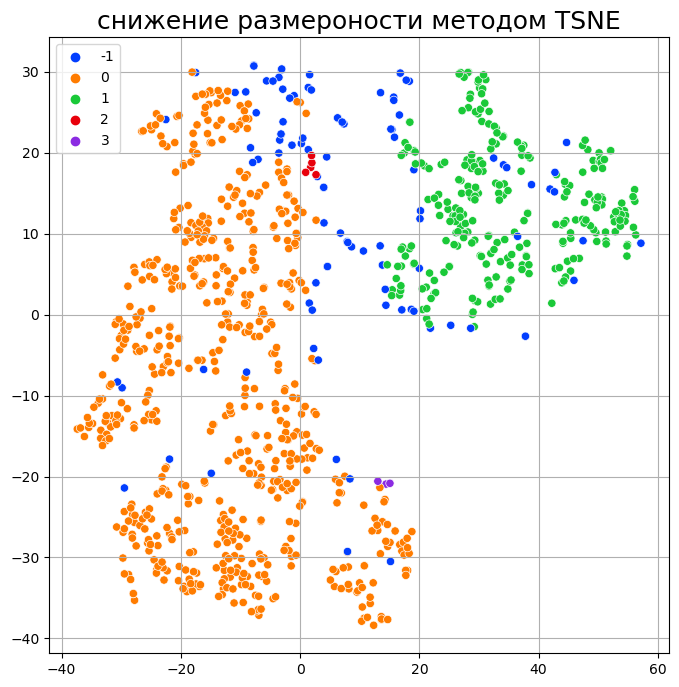

2.02


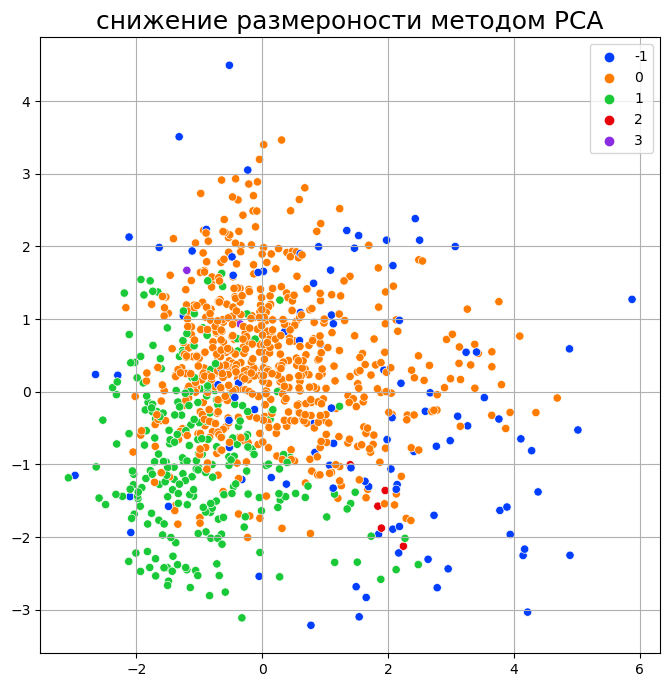

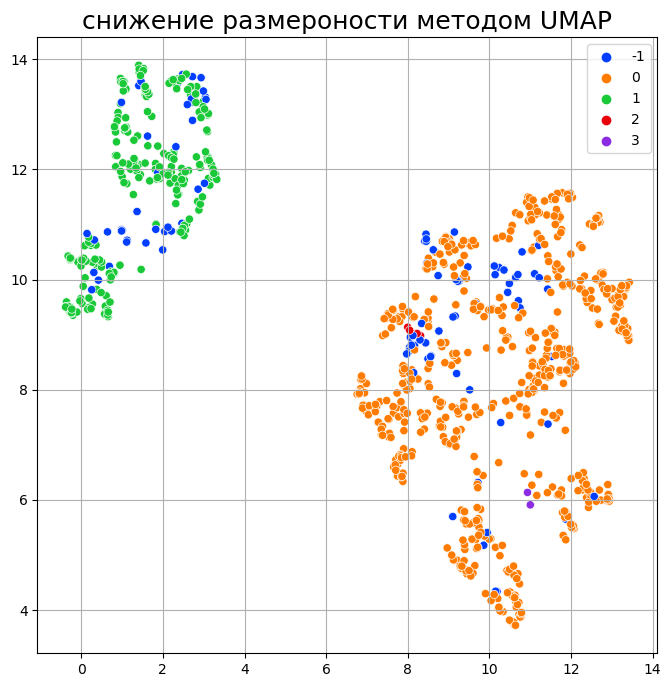

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


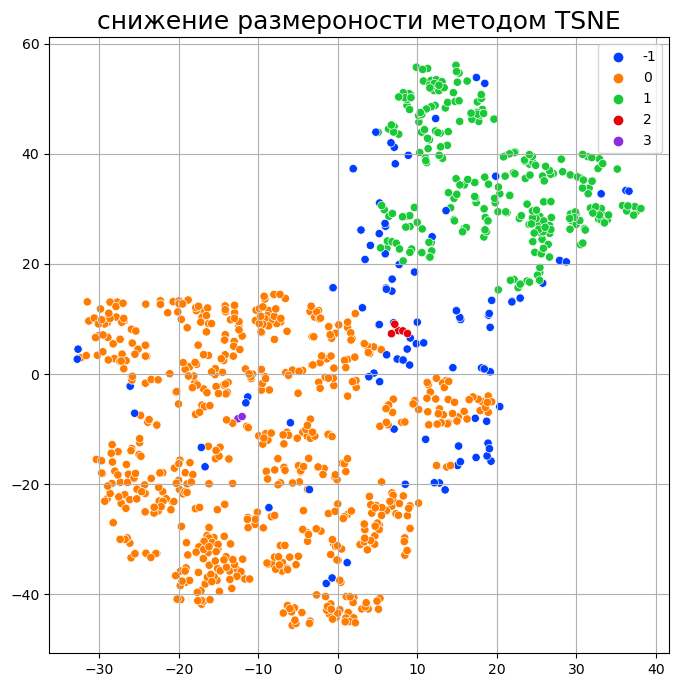

2.03


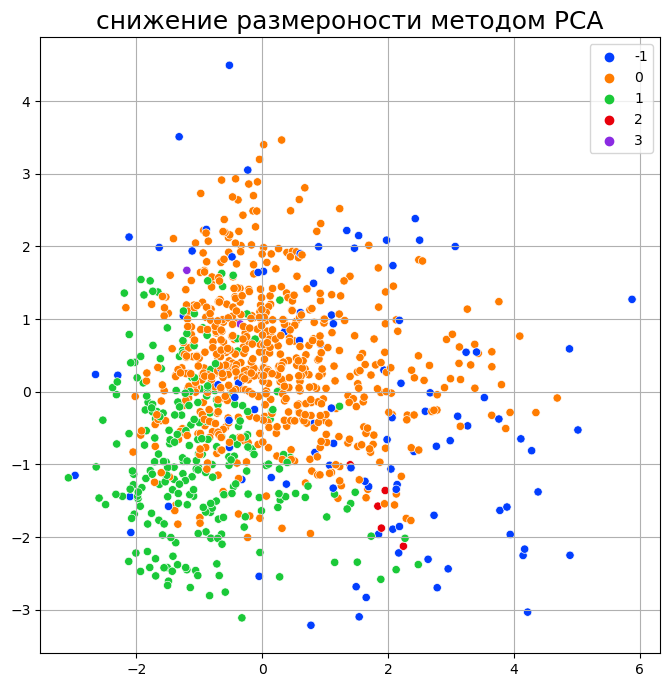

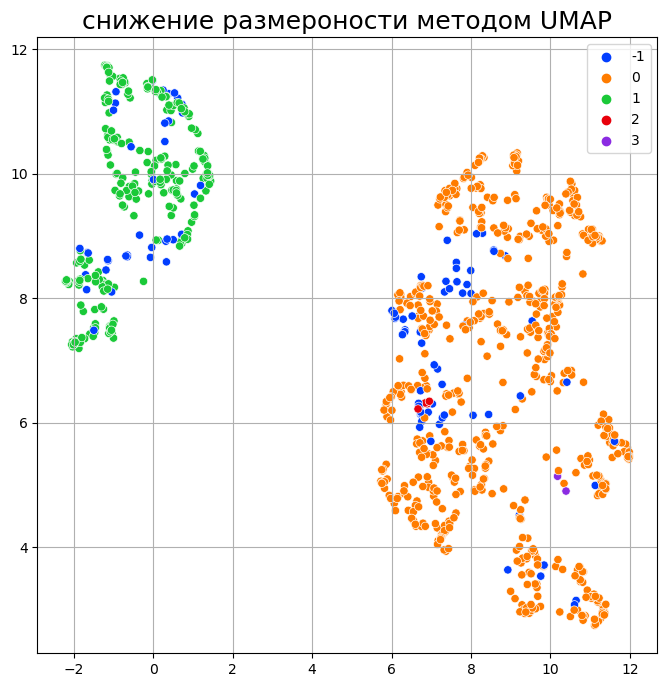

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


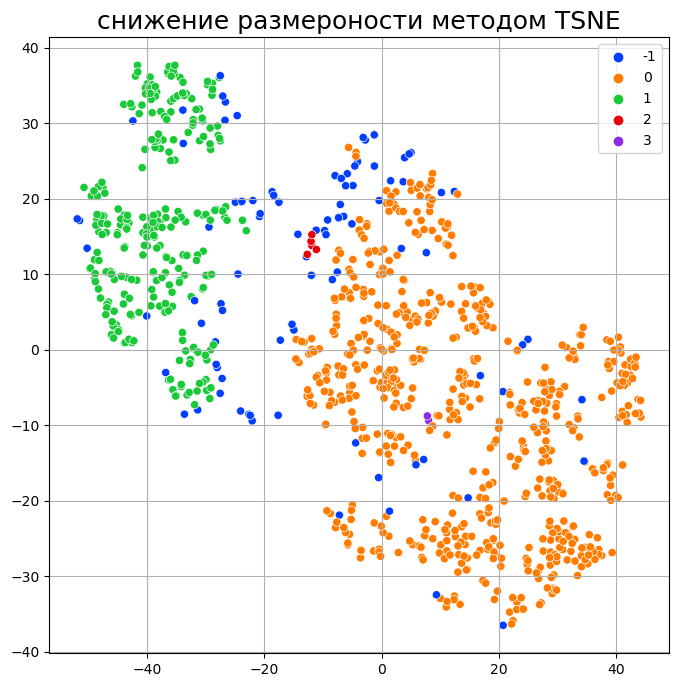

2.04


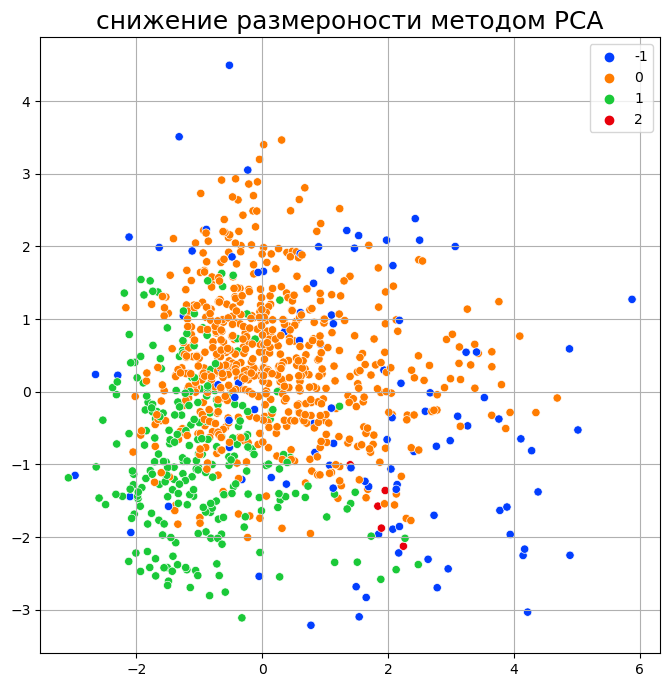

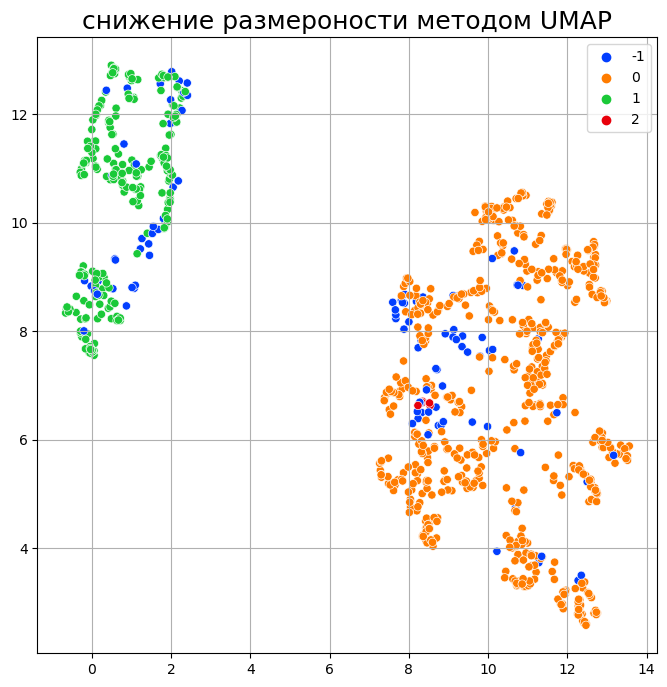

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


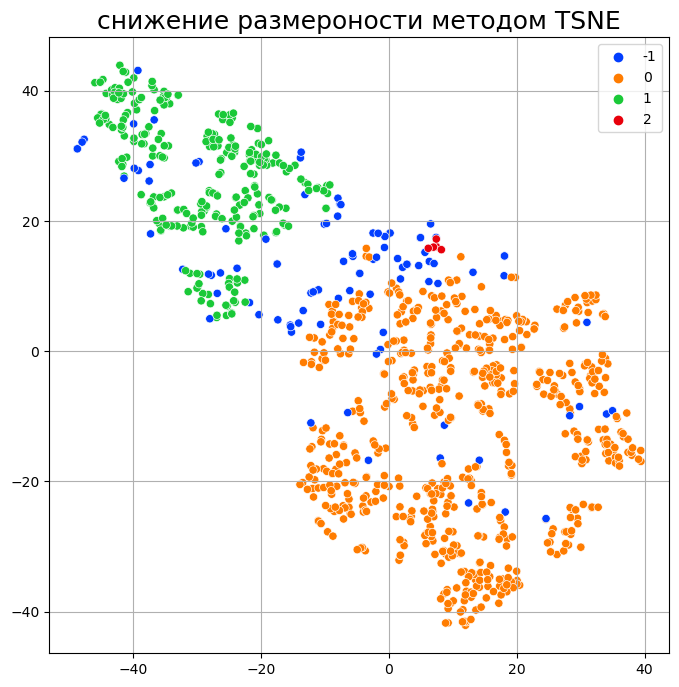

2.05


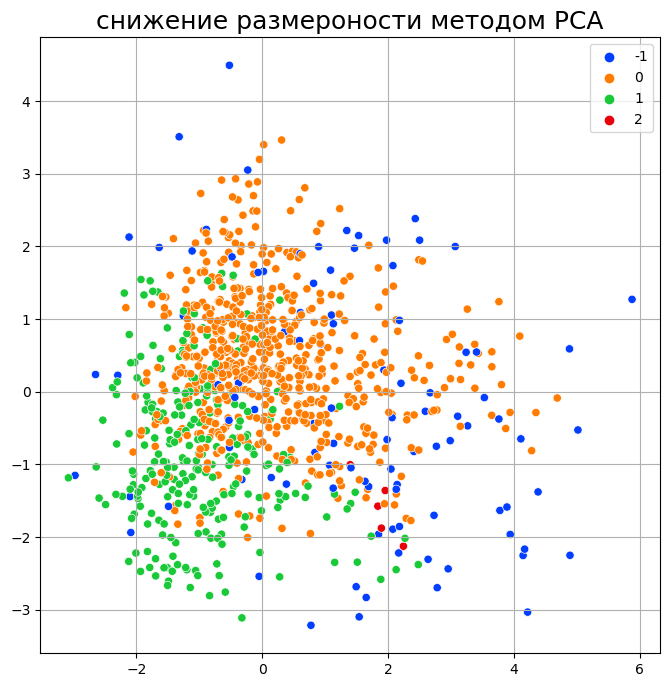

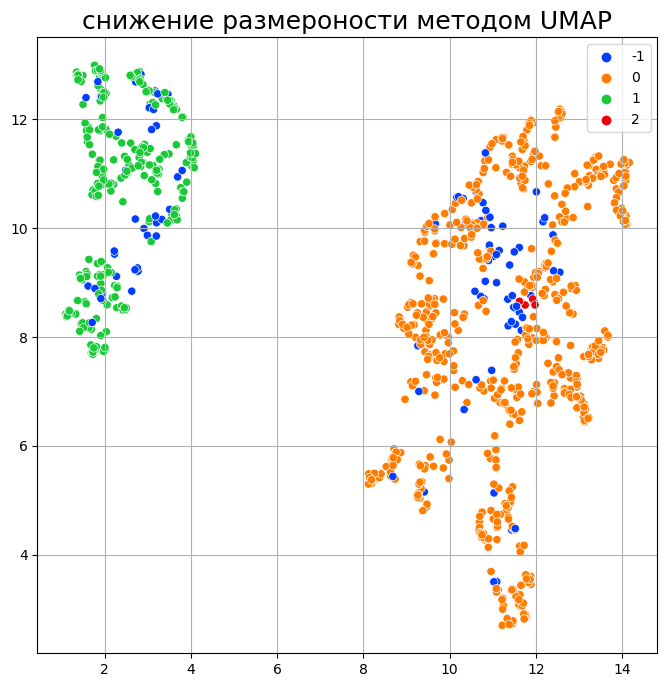

C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\smndy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


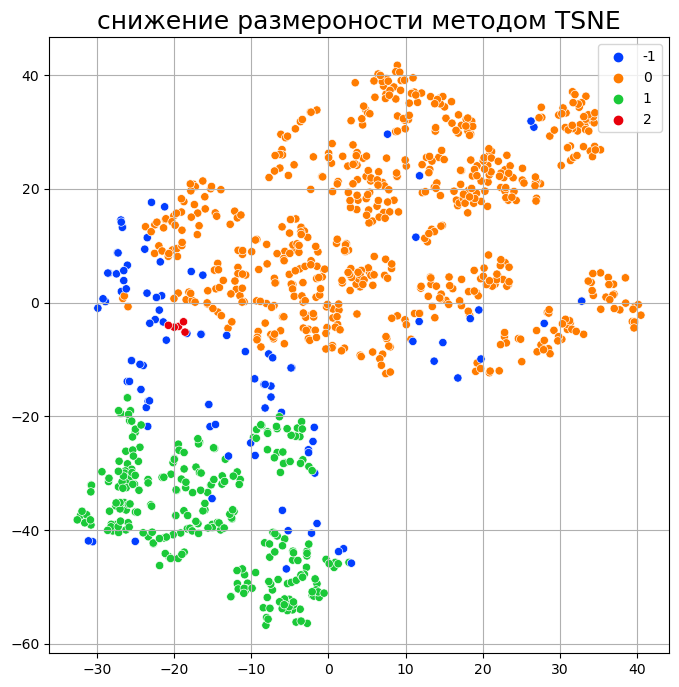

In [75]:
# прогоню через цикл для epsilons = 2 - 2.05
ar  = range(200, 206, 1) #костыль

for el in ar:
    print(el/100)
    dbscan = DBSCAN(eps=el/100) 
    dbscan.fit(X)

    df_clustered_dbscan = df.copy()
    df_clustered_dbscan['Cluster'] = dbscan.labels_

    visualization(X, dbscan.labels_)

### вывод все методы показали 3 - 5 класетров. Использую 5 кластеров по k-means

# Часть 3. Интерпретация.

1.Теперь ваша задача - попытаться проинтерпретировать получившиеся кластеры, начните с простого расчета средних значений признаков для каждого из кластеров, есть ли интересные закономерности?

2.Теперь постройте boxplot-ы для каждого признака, сгруппировав значения по кластерам, по каким признакам заметно наибольшее отличие кластеров друг от друга? Можно ли их интерпретировать?

In [76]:
# собираю дата-сет для анализа к data прикрепляю столбец 'Cluster' (5 кластеров, последнее сохранение)
df_clustered = pd.concat([data, df_clustered_kmeans['Cluster']], axis=1)

In [77]:
df_clustered.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  Cluster  
0           1169         6             radio/TV        0  
1           5951        48             radio/TV        1  
2           2096        12            education        2  
3           7882        42  furniture/equipment        1  
4           4870        24                  car        2

In [78]:
df_clustered['Cluster'].value_counts(normalize=True) #размеры кластеров неравны

4    0.239
3    0.232
2    0.189
0    0.177
1    0.163
Name: Cluster, dtype: float64

In [79]:
# агрегирую по числовым переменным, в т.ч. 
df_clustered.groupby('Cluster')[df.select_dtypes(['int64']).columns].agg({'Age': ['mean', 'median', 'count'], 
                                                                            'Job': ['mean', 'median', 'count'], 
                                                                            'Credit amount': ['mean', 'median', 'count'], 
                                                                            'Duration': ['mean', 'median', 'count']})

Age                    Job              Credit amount          \
              mean median count      mean median count          mean  median   
Cluster                                                                        
0        40.497175   38.0   177  1.915254    2.0   177   2374.096045  2012.0   
1        37.184049   35.0   163  2.349693    2.0   163   8131.932515  7485.0   
2        38.195767   36.0   189  1.740741    2.0   189   2384.873016  2002.0   
3        33.452586   32.0   232  1.862069    2.0   232   2353.254310  2034.5   
4        30.698745   27.0   239  1.761506    2.0   239   2212.728033  1842.0   

                Duration               
        count       mean median count  
Cluster                                
0         177  17.209040   15.0   177  
1         163  38.582822   36.0   163  
2         189  16.375661   15.0   189  
3         232  18.918103   18.0   232  
4         239  17.087866   15.0   239

####  кластер 0 выделяется суммой и продолжительностью кредита

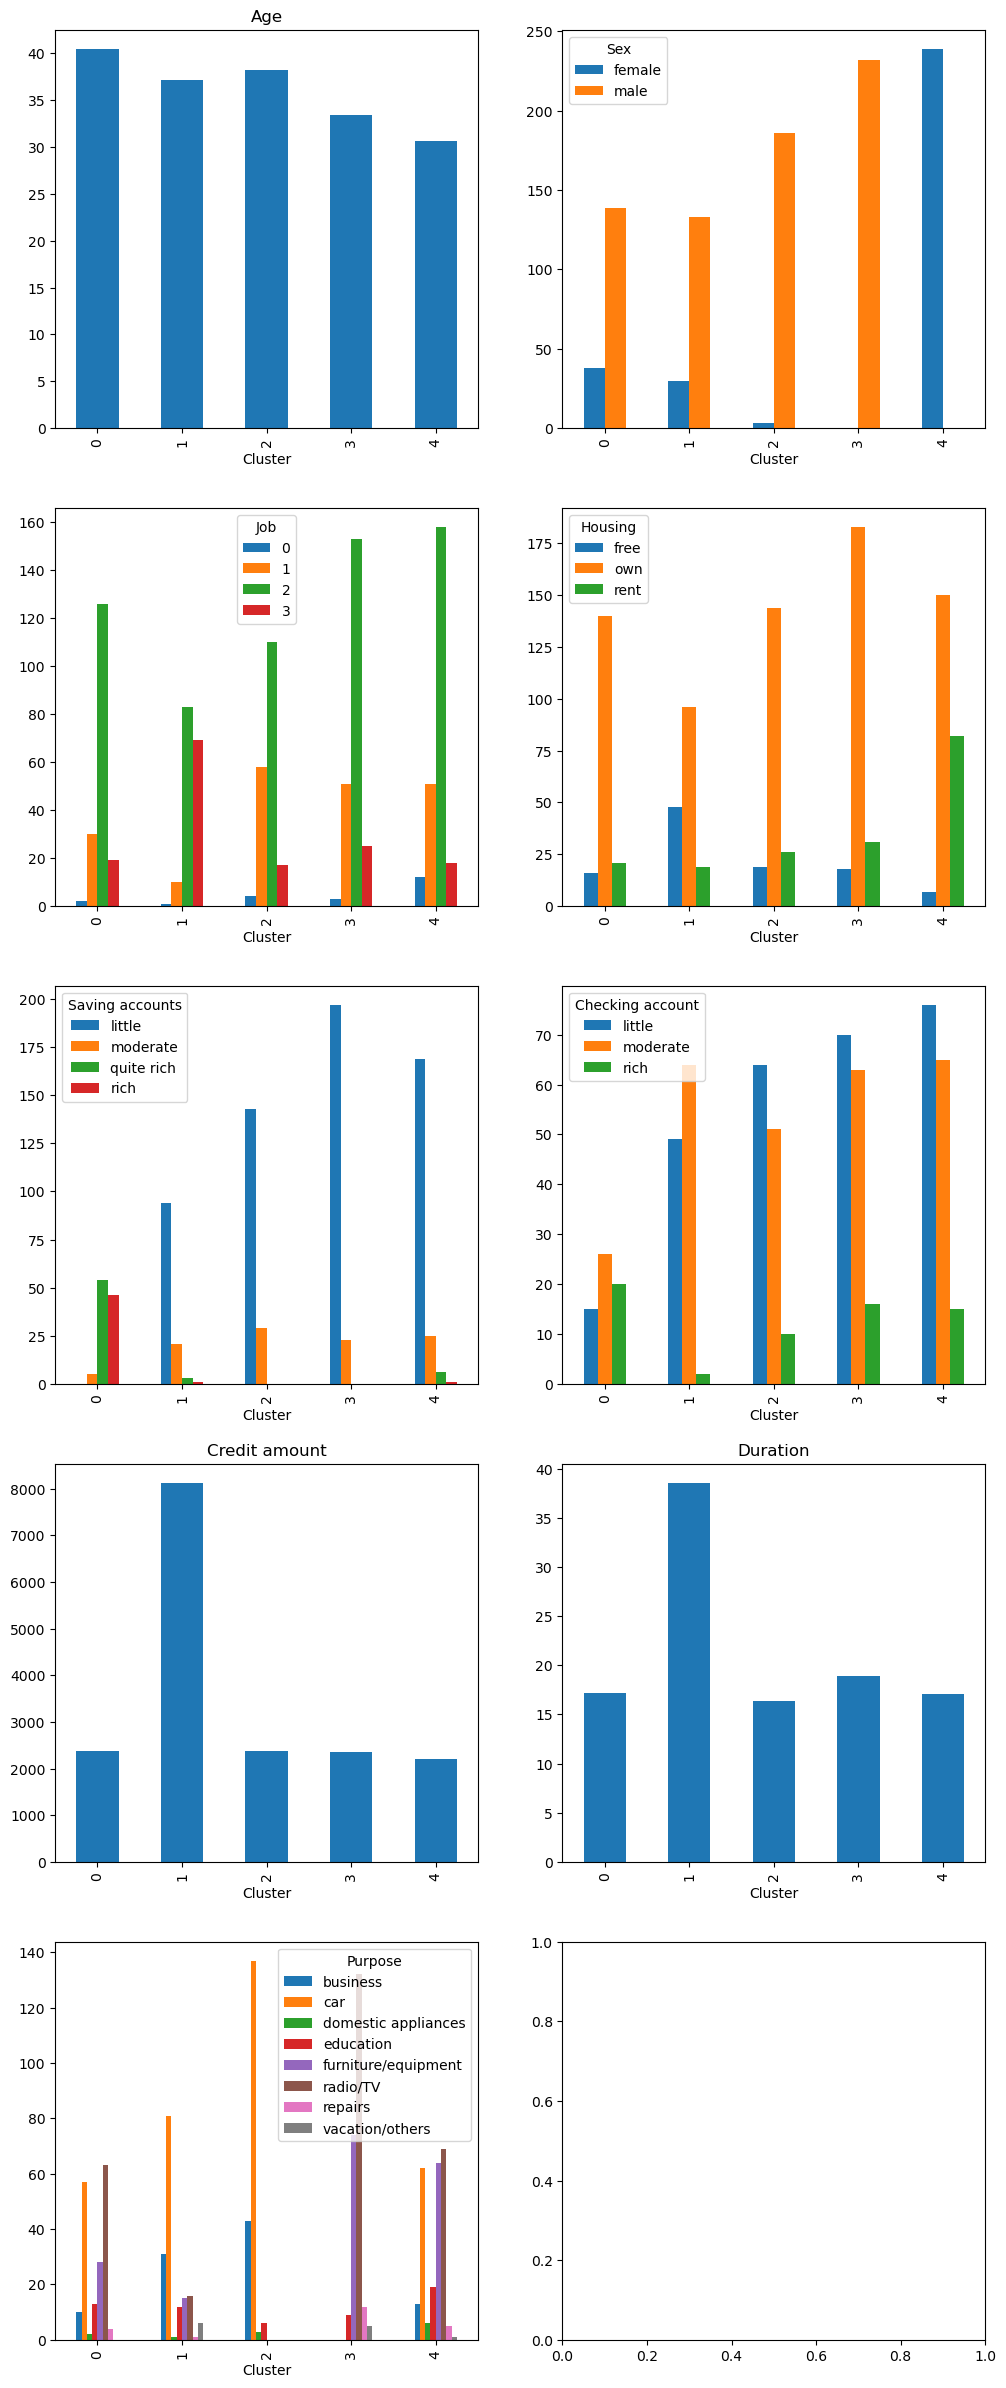

In [80]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,30))

df_clustered.groupby(['Cluster']).mean()['Age'].plot(kind='bar', ax=axs[0, 0])
df_clustered.groupby(['Cluster', 'Sex']).size().unstack().plot(kind='bar', ax=axs[0, 1])
df_clustered.groupby(['Cluster', 'Job']).size().unstack().plot(kind='bar', ax=axs[1, 0])
df_clustered.groupby(['Cluster', 'Housing']).size().unstack().plot(kind='bar', ax=axs[1, 1])
df_clustered.groupby(['Cluster', 'Saving accounts']).size().unstack().plot(kind='bar', ax=axs[2, 0])
df_clustered.groupby(['Cluster', 'Checking account']).size().unstack().plot(kind='bar', ax=axs[2, 1])
df_clustered.groupby(['Cluster']).mean()['Credit amount'].plot(kind='bar', ax=axs[3, 0])
df_clustered.groupby(['Cluster']).mean()['Duration'].plot(kind='bar', ax=axs[3, 1])
df_clustered.groupby(['Cluster', 'Purpose']).size().unstack().plot(kind='bar', ax=axs[4, 0])

axs[0, 0].set_title('Age')
axs[3, 0].set_title('Credit amount')
axs[3, 1].set_title('Duration')

plt.show()

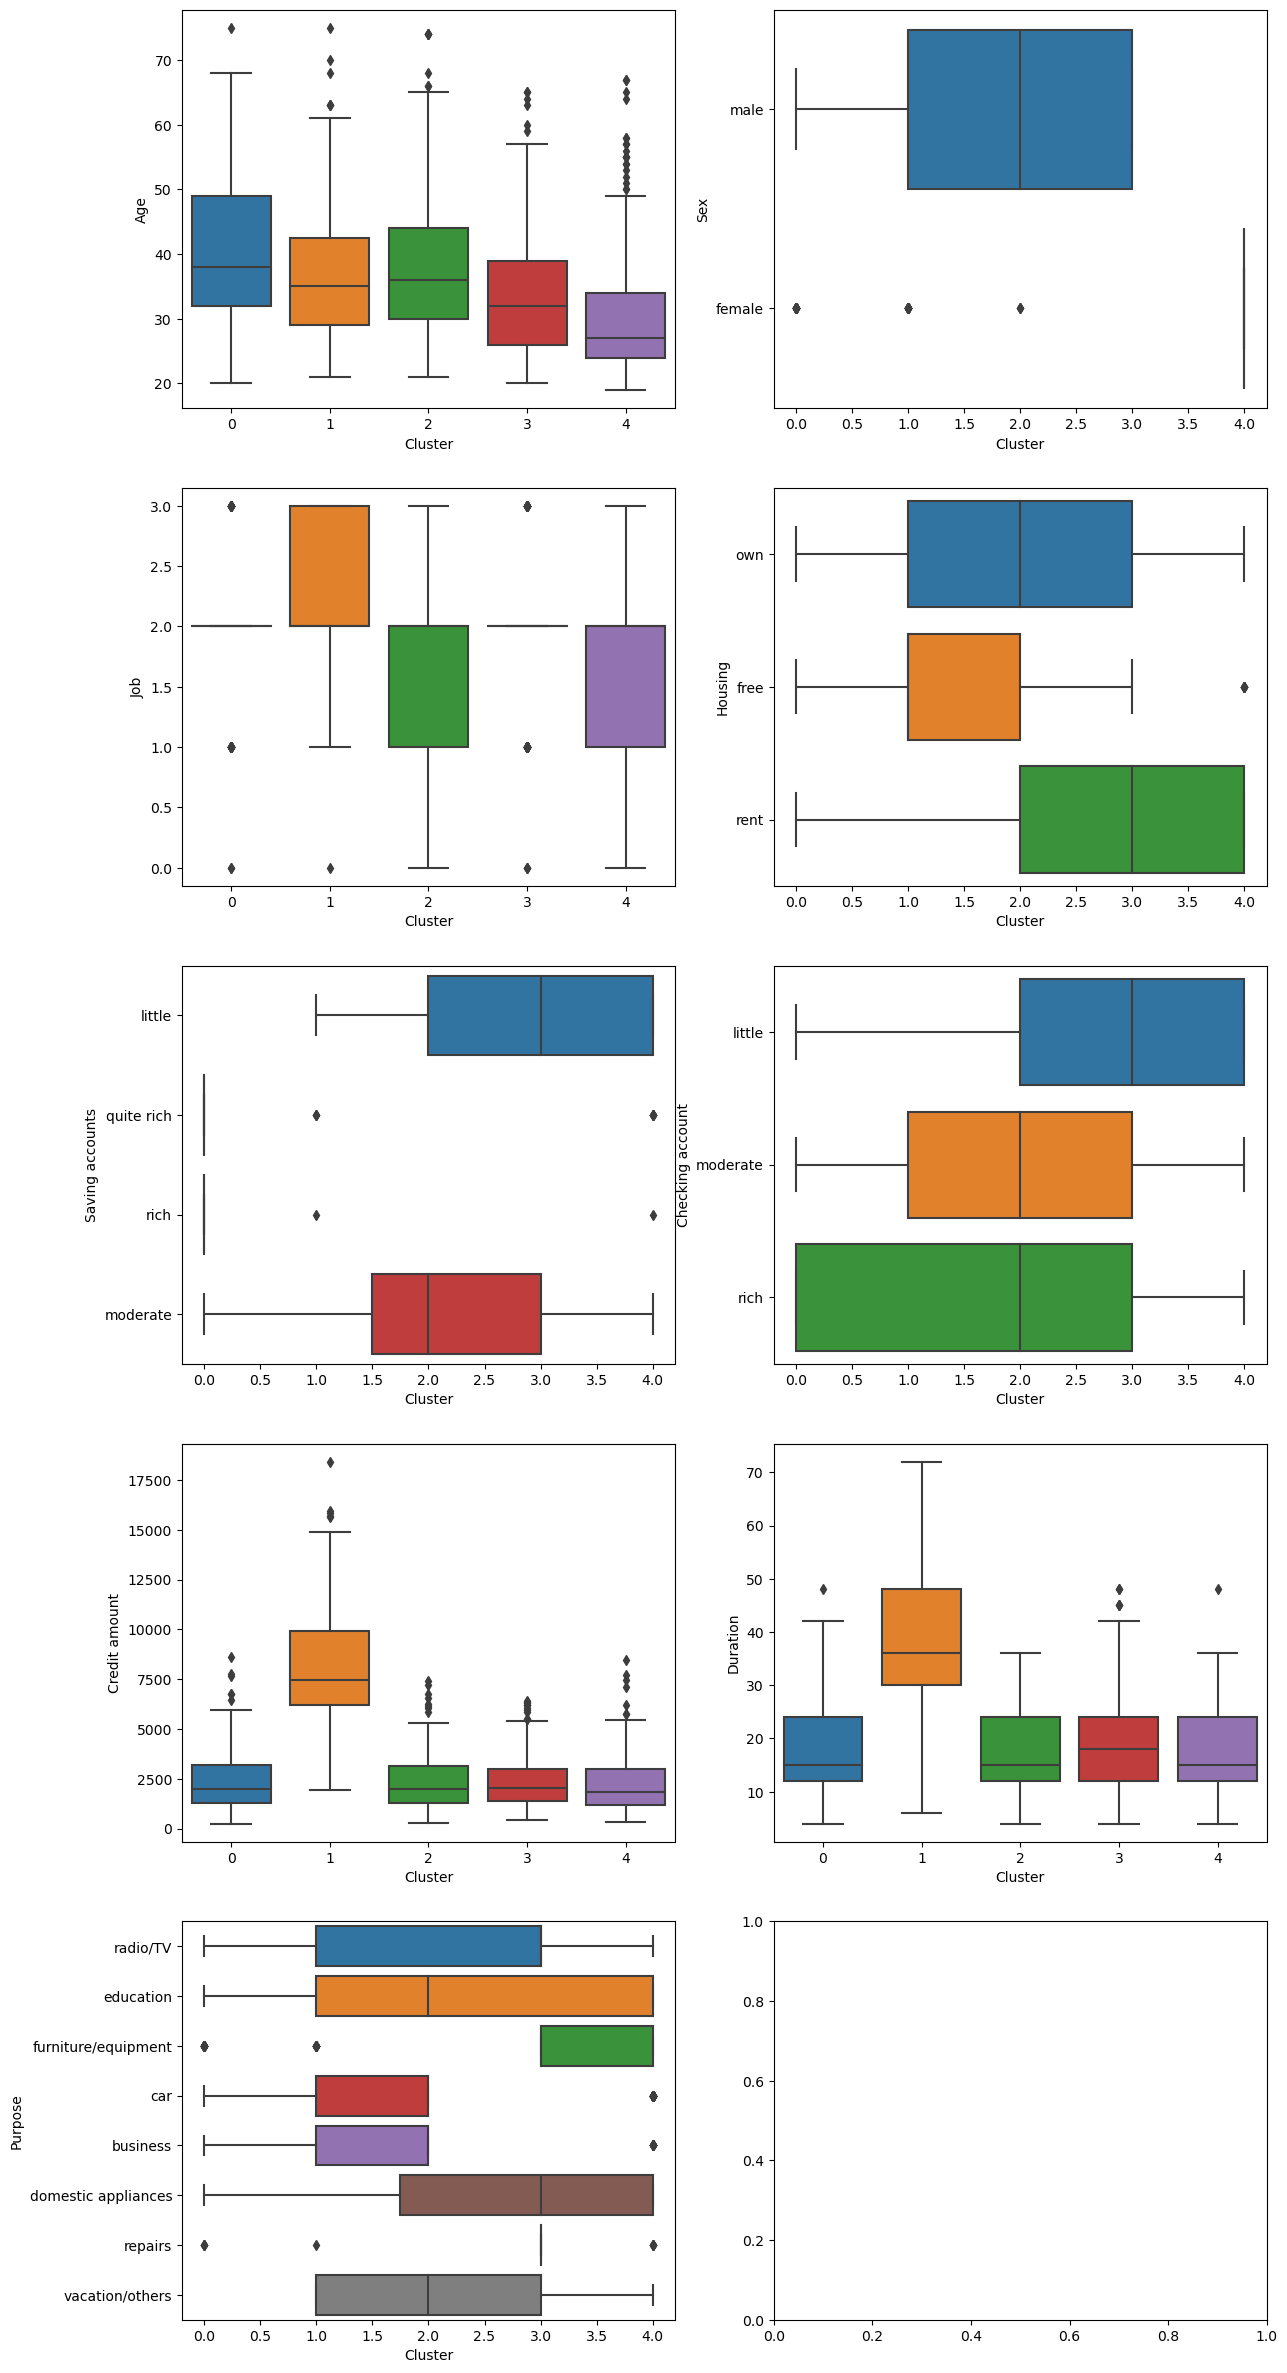

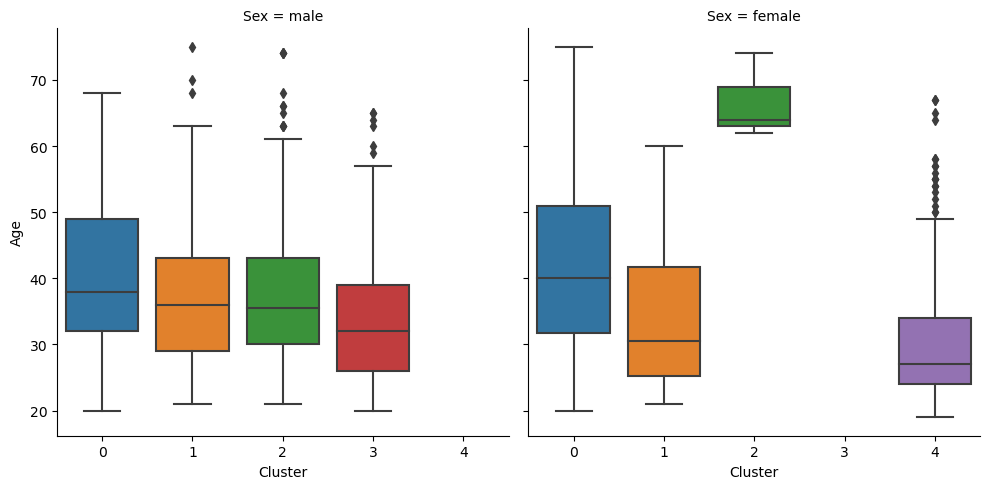

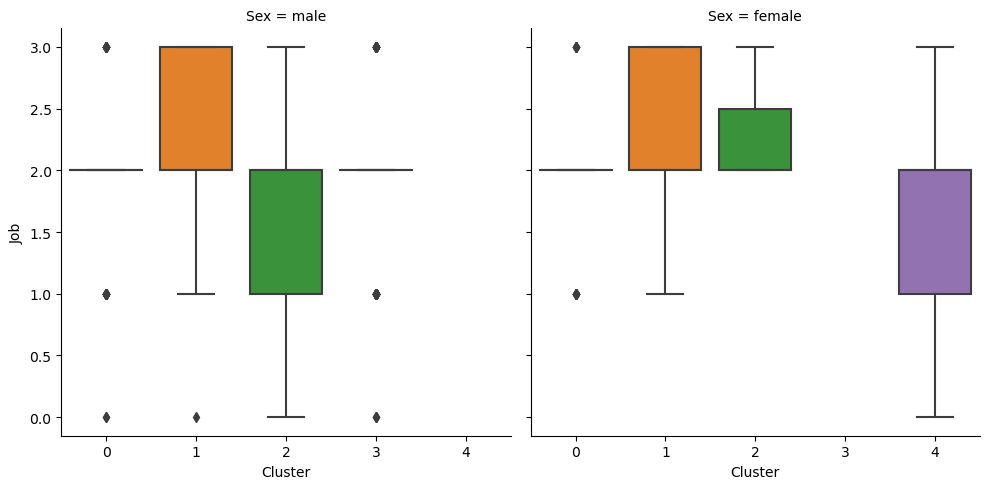

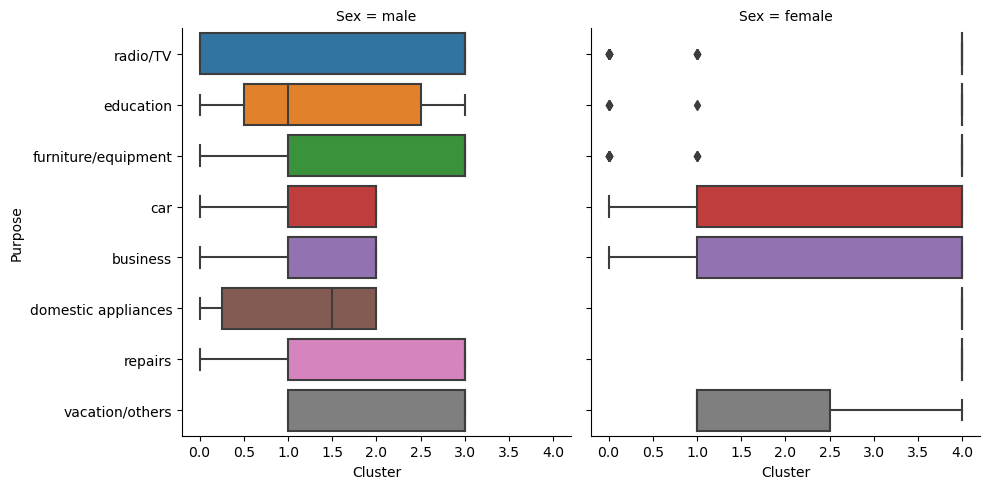

In [81]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,30))

sns.boxplot(x='Cluster', y='Age', data=df_clustered, ax=axs[0, 0])
sns.boxplot(x='Cluster', y='Sex', data=df_clustered, ax=axs[0, 1])
sns.boxplot(x='Cluster', y='Job', data=df_clustered, ax=axs[1, 0])
sns.boxplot(x='Cluster', y='Housing', data=df_clustered, ax=axs[1, 1])
sns.boxplot(x='Cluster', y='Saving accounts', data=df_clustered, ax=axs[2, 0])
sns.boxplot(x='Cluster', y='Checking account', data=df_clustered, ax=axs[2, 1])
sns.boxplot(x='Cluster', y='Credit amount', data=df_clustered, ax=axs[3, 0])
sns.boxplot(x='Cluster', y='Duration', data=df_clustered, ax=axs[3, 1])
sns.boxplot(x='Cluster', y='Purpose', data=df_clustered, ax=axs[4, 0])

sns.catplot(x='Cluster', y='Age', data=df_clustered, kind="box", col='Sex')
sns.catplot(x='Cluster', y='Job', data=df_clustered, kind="box", col='Sex')
sns.catplot(x='Cluster', y='Purpose', data=df_clustered, kind="box", col='Sex')

plt.show()

## Вывод
 - Кластер 0 - Большие кредиты на большой срок для людей с квалифицированной и высококвалифицированной работой. Почти все мужчины, кредиты на большую сумму и длительный срок, основная цель - "в дело" или авто.
 - Кластер 1 - Молодые мужчины с квалифицированной работой, с жильем, с небольшими сберегательным и чековым счетами, средние кредиты на мебель, ТВ и прочее.
 - Кластер 2 - Молодые женщины с квалифицированной работой, со своим или арендным жильем, с небольшими сберегательным и чековым счетами (либо без чекового), средние кредиты на разные нужды
 - Кластер 3 - В основном кредиты на машину от мужчин. Мужчины с квалифицированной и не очень работой, примущественно со своим жильем с небольшим сберегательным счетом и средним чековым, средний кредит по сумме и времени, преимущественно на машину
 - Кластер 4 - Возврастные люди, по большей части мужчины, с квалифицированной работой, и со своим жильем, с большим или очень большим сберегательным счетом, с большим чековым счетом либо без него, средний кредит по сумме и времени на разные нужды.